# Test Harness Jupyter Notebook for [thesis name here]

## *About*
TODO

# Geoscience and Remote Sensing Society (GRSS) Data Fusion Contest (DFC) 2018 Univerisity of Houston Dataset

## *LiDAR*
- **Lidar sensor**: Optech Titan MW (14SEN/CON340) w/ integrated camera (This is a multispectral lidar sensor)
- **Ground Sampling Distance (GSD)**: 0.5 meters (for point clouds, multispectral intensity, DSM, and DEM)
- **Lidar MS Channel #1 (C1)**: 1550nm wavelength (near infrared)
- **Lidar MS Channel #2 (C2)**: 1064nm wavelength (near infrared)
- **Lidar MS Channel #3 (C3)**: 532nm wavelength (green)
- **DSM_C12**: a first surface model (DSM) generated from first returns detected on Titan channels 1 and 2. The elevations of the first returns were interpolated to a 50cm (0.5m) grid using Kriging with a search radius of 5 meters.
- **DEM_C123_3msr**: a bare-earth digital elevation model (DEM) generated from returns classified as ground from all three Titan channels. The elevations of the first returns were interpolated to a 50cm (0.5m) grid using Kriging with a search radius of 3 meters. This model represents terrain with data voids within the footprints of buildings and other manmade structures.
- **DEM_C123_TLI**: a bare-earth DEM generated from returns classified as ground from all three Titan channels. The elevations of the first returns were interpolated to a 50cm (0.5m) grid using a *triangulation with linear interpolation* algorithm. This model represents terrain where the voids of footprints of buildings and other manmade structures have been filled by the algorithm. 
- **DEM+B_C123**: a hybrid DEM that combines returns that were classified as coming from buildings and the ground detected in all three Titan channels. The elevations of the returns were interpolated to a 50cm (0.5m) grid using Kriging with a search radius of 5 meters.

## *Hyperspectral*
- **Hyperspectral Image (HSI) sensor**: ITRES CASI 1500
- **Ground Sampling Distance (GSD)**: 1 meter
- **Number of spectral bands**: 48
- **Spectral range of data**: 380 - 1050nm



# --- TO-DO List ---
- Create thresholding filter for lidar intensity raster and DSM data
    - In the contest paper "Those pixel values that are greater than a threshold T are replaced with the minimum value in the data. We set T as 1*e*4 and 1*e*10 for LiDAR intensity raster data and DSM data, respectively"
- Create normalized DSM (NDSM) to feed to algorithm (NDSM = DSM - DEM)
- For all data (Hyperspectral, MS LiDAR, NDSM) normalize each feature dimension into range of \[0,1\]
- Contest winner conducted image partitioning, partitioning the main image into 40 sub-images with a size of 1202x300
    - During the test phase, there was no need to restore the gradient of the network anymore so the full test image is partitioned into 15 sub-images with a size of 2404 x 600
- Image blurring (smoothing) w/ Gaussian filter?
- In EDA, do histograms of Hyperspectral and lidar values, make it interactive to do over all classes as well as overall

# 1) Install/import required libraries and set up environment

In [1]:
#@title Install GDAL, Rasterio, and Spectral libraries
# Install GDAL
#!apt install gdal-bin python-gdal python3-gdal 

# Install Rasterio
#!pip install rasterio

# Install Spectral (do I need git clone?)
#!pip install spectral
#!git clone https://github.com/spectralpython/spectral.git

In [2]:
#@title Import libraries to notebook
### Standard Python Libraries ###
import argparse
import collections
from copy import deepcopy
import gc
from operator import truediv
import os
import time

### Data Manipulation Libaries ###
import numpy as np
import pandas as pd

### Hyperspectral Libaries ###
import rasterio
from rasterio.enums import Resampling
from rasterio.windows import Window
import spectral

### Data Visualization Libraries ###
import matplotlib.pyplot as plt

# import Jupyter NB widgets
import ipywidgets as widgets
from IPython.display import display

### Machine Learning Libraries ###
import scipy.io as sio
from sklearn import metrics, preprocessing
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras.callbacks as kcallbacks
from tensorflow.keras.layers import (
    Activation,
    AveragePooling3D,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv3D,
    Convolution3D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling3D,
    Input,
    MaxPooling3D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical


In [3]:
#@title Environment Setup
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 2) Set up GRSS DFC 2018 University of Houston Dataset

In [4]:
#@title Initialize GRSS DFC 2018 UH constants

# Setup global variables for grss_dfc_2018 datset
# Path to directory containing all GRSS 2018 Data Fusion Contest
# University of Houston image data
UH_2018_DATASET_DIRECTORY_PATH = 'datasets/grss_dfc_2018/'

# Following paths are assumed to be from the root UH 2018 dataset path
UH_2018_TRAINING_GT_IMAGE_PATH = 'TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif'
UH_2018_TESTING_GT_IMAGE_PATH = 'TestingGT/Test_Labels.tif'
UH_2018_HS_IMAGE_PATH = 'FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix'
UH_2018_LIDAR_DSM_PATH = 'Lidar GeoTiff Rasters/DSM_C12/UH17c_GEF051.tif'
UH_2018_LIDAR_DEM_3MSR_PATH = 'Lidar GeoTiff Rasters/DEM_C123_3msr/UH17_GEG051.tif'
UH_2018_LIDAR_DEM_TLI_PATH = 'Lidar GeoTiff Rasters/DEM_C123_TLI/UH17_GEG05.tif'
UH_2018_LIDAR_DEM_B_PATH = 'Lidar GeoTiff Rasters/DEM+B_C123/UH17_GEM051.tif'
UH_2018_LIDAR_INTENSITY_1550NM_PATH = 'Lidar GeoTiff Rasters/Intensity_C1/UH17_GI1F051.tif'
UH_2018_LIDAR_INTENSITY_1064NM_PATH = 'Lidar GeoTiff Rasters/Intensity_C2/UH17_GI2F051.tif'
UH_2018_LIDAR_INTENSITY_532NM_PATH = 'Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif'

# Paths, in order of tile, for the very high resolution RGB image
UH_2018_VHR_IMAGE_PATHS = [
    [
        'Final RGB HR Imagery/UH_NAD83_271460_3290290.tif',
        'Final RGB HR Imagery/UH_NAD83_272056_3290290.tif',
        'Final RGB HR Imagery/UH_NAD83_272652_3290290.tif',
        'Final RGB HR Imagery/UH_NAD83_273248_3290290.tif',
        'Final RGB HR Imagery/UH_NAD83_273844_3290290.tif',
        'Final RGB HR Imagery/UH_NAD83_274440_3290290.tif',
        'Final RGB HR Imagery/UH_NAD83_275036_3290290.tif',
    ],
    [
        'Final RGB HR Imagery/UH_NAD83_271460_3289689.tif',
        'Final RGB HR Imagery/UH_NAD83_272056_3289689.tif',
        'Final RGB HR Imagery/UH_NAD83_272652_3289689.tif',
        'Final RGB HR Imagery/UH_NAD83_273248_3289689.tif',
        'Final RGB HR Imagery/UH_NAD83_273844_3289689.tif',
        'Final RGB HR Imagery/UH_NAD83_274440_3289689.tif',
        'Final RGB HR Imagery/UH_NAD83_275036_3289689.tif',
    ],
]

# Number of rows and columns in the overall dataset image such that 
# parts of the dataset can be matched with the ground truth
UH_2018_NUM_TILE_COLUMNS = 7
UH_2018_NUM_TILE_ROWS = 2

# List of tuples corresponding to the image tiles that match the ground
# truth for the training set
UH_2018_TRAINING_GT_TILES = ((1,1), (1,2), (1, 3), (1, 4))

# List of tuples corresponding to the image tiles that match the ground
# truth for the testing set
UH_2018_TESTING_GT_TILES = ((0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6),
                            (1,0),                             (1,5), (1,6))

# Mapping of overall dataset training ground truth tile indices to the
# tile indices of the actual ground truth image
UH_2018_TRAINING_GT_TILE_OFFSETS = {
    (1,1) : (0,0),
    (1,2) : (0,1),
    (1,3) : (0,2),
    (1,4) : (0,3)
}

# GSD = Ground Sampling Distance
UH_2018_VHR_GSD = 0.05  # Very high resolution image GSD in meters
UH_2018_HS_GSD = 1.0    # Hyperspectral image GSD in meters
UH_2018_LIDAR_GSD = 0.5 # LiDAR raster image GSD in meters
UH_2018_GT_GSD = 0.5    # Ground truth images GSD in meters

# A list of the wavelength values for each lidar band channel
UH_2018_LIDAR_BAND_WAVELENGTHS = [
    '1550nm',
    '1064nm',
    '532nm'
]

# Number of hyperspectral band channels
UH_2018_NUM_HS_BANDS = 48

# Threshold value for hyperspectral band intensities
UH_2018_HS_BAND_THRES = 100_000

# Number of multispectral LiDAR band channels
UH_2018_NUM_LIDAR_BANDS = 3

# Threshold value for LiDAR multispectral intensities
UH_2018_MS_INTENSITY_THRESHOLD = 1e4

# Threshold value for LiDAR DSM
UH_2018_DSM_THRESHOLD = 1e10

# A list of the wavelength values for each of the hyperspectal band
# channels
UH_2018_HS_BAND_WAVELENGTHS = [
    '374.395nm +/- 7.170nm',
    '388.733nm +/- 7.168nm', 
    '403.068nm +/- 7.167nm', 
    '417.401nm +/- 7.166nm', 
    '431.732nm +/- 7.165nm', 
    '446.061nm +/- 7.164nm', 
    '460.388nm +/- 7.163nm', 
    '474.712nm +/- 7.162nm', 
    '489.035nm +/- 7.161nm', 
    '503.356nm +/- 7.160nm', 
    '517.675nm +/- 7.159nm', 
    '531.992nm +/- 7.158nm', 
    '546.308nm +/- 7.158nm', 
    '560.622nm +/- 7.157nm', 
    '574.936nm +/- 7.156nm', 
    '589.247nm +/- 7.156nm', 
    '603.558nm +/- 7.155nm', 
    '617.868nm +/- 7.155nm', 
    '632.176nm +/- 7.154nm', 
    '646.484nm +/- 7.154nm', 
    '660.791nm +/- 7.153nm', 
    '675.097nm +/- 7.153nm', 
    '689.402nm +/- 7.153nm', 
    '703.707nm +/- 7.152nm', 
    '718.012nm +/- 7.152nm', 
    '732.316nm +/- 7.152nm', 
    '746.620nm +/- 7.152nm', 
    '760.924nm +/- 7.152nm', 
    '775.228nm +/- 7.152nm', 
    '789.532nm +/- 7.152nm', 
    '803.835nm +/- 7.152nm', 
    '818.140nm +/- 7.152nm', 
    '832.444nm +/- 7.152nm', 
    '846.749nm +/- 7.153nm', 
    '861.054nm +/- 7.153nm', 
    '875.360nm +/- 7.153nm', 
    '889.666nm +/- 7.153nm', 
    '903.974nm +/- 7.154nm', 
    '918.282nm +/- 7.154nm', 
    '932.591nm +/- 7.155nm', 
    '946.901nm +/- 7.155nm', 
    '961.212nm +/- 7.156nm', 
    '975.525nm +/- 7.157nm', 
    '989.839nm +/- 7.157nm', 
    '1004.154nm +/- 7.158nm', 
    '1018.471nm +/- 7.159nm', 
    '1032.789nm +/- 7.160nm', 
    '1047.109nm +/- 7.160nm', 
]

# A list of hexidecimal color values corresponding to the wavelength of
# the hyperspectral bands
UH_2018_BAND_RGB = [
    '#610061',  #374nm
    '#780088',  #389nm
    '#8300c0',  #403nm
    '#7100f4',  #417nm
    '#3300ff',  #432nm
    '#002fff',  #446nm
    '#007bff',  #460nm
    '#00c0ff',  #475nm
    '#00fbff',  #489nm
    '#00ff6e',  #503nm
    '#2dff00',  #518nm
    '#65ff00',  #532nm
    '#96ff00',  #546nm
    '#c6ff00',  #561nm
    '#f0ff00',  #575nm
    '#ffe200',  #589nm
    '#ffb000',  #604nm
    '#ff7e00',  #618nm
    '#ff4600',  #632nm
    '#ff0000',  #646nm
    '#fd0000',  #661nm
    '#fb0000',  #675nm
    '#fa0000',  #689nm
    '#f80000',  #704nm
    '#de0000',  #718nm
    '#c40000',  #732nm
    '#a70000',  #747nm
    '#8a0000',  #761nm
    '#6d0000',  #775nm
    '#610000',  #790nm (representation)
    '#5e0000',  #804nm (representation)
    '#5c0000',  #818nm (representation)
    '#590000',  #843nm (representation)
    '#570000',  #847nm (representation)
    '#540000',  #862nm (representation)
    '#510000',  #875nm (representation)
    '#4f0000',  #890nm (representation)
    '#4c0000',  #904nm (representation)
    '#4a0000',  #918nm (representation)
    '#470000',  #933nm (representation)
    '#440000',  #947nm (representation)
    '#420000',  #961nm (representation)
    '#3f0000',  #976nm (representation)
    '#3d0000',  #990nm (representation)
    '#3a0000',  #1004nm (representation)
    '#370000',  #1018nm (representation)
    '#350000',  #1033nm (representation)
    '#320000',  #1047nm (representation)
]

# Number of defined classes in the ground truth image
NUMBER_OF_UH_2018_CLASSES = 20

# Map of classes where the key is the value of the pixel in the
# ground truth image
UH_2018_CLASS_MAP = {
    0:  'Undefined',
    1:  'Healthy grass',
    2:  'Stressed grass',
    3:  'Artificial turf',
    4:  'Evergreen trees',
    5:  'Deciduous trees',
    6:  'Bare earth',
    7:  'Water',
    8:  'Residential buildings',
    9:  'Non-residential buildings',
    10: 'Roads',
    11: 'Sidewalks',
    12: 'Crosswalks',
    13: 'Major thoroughfares',
    14: 'Highways',
    15: 'Railways',
    16: 'Paved parking lots',
    17: 'Unpaved parking lots',
    18: 'Cars',
    19: 'Trains',
    20: 'Stadium seats',
}
    
# List of classes where the index is the value of the pixel in the
# ground truth image
UH_2018_CLASS_LIST = [
    'Undefined',
    'Healthy grass',
    'Stressed grass',
    'Artificial turf',
    'Evergreen trees',
    'Deciduous trees',
    'Bare earth',
    'Water',
    'Residential buildings',
    'Non-residential buildings',
    'Roads',
    'Sidewalks',
    'Crosswalks',
    'Major thoroughfares',
    'Highways',
    'Railways',
    'Paved parking lots',
    'Unpaved parking lots',
    'Cars',
    'Trains',
    'Stadium seats',
]

# Number of class labels for the University of Houston 2018 dataset
# (one is subtracted to exclude the 'undefined' class)
UH_2018_NUM_CLASSES = len(UH_2018_CLASS_LIST) - 1

In [5]:
class UH_2018_Dataset:
    """
    Class for loading and manipulating different parts of the GRSS 2018
    Data Fusion Contest University of Houston dataset.
    """

    def __init__(self, dataset_path=UH_2018_DATASET_DIRECTORY_PATH):

        # Set dataset file paths
        self.path_to_dataset_directory = dataset_path
        self.path_to_training_gt_image = UH_2018_TRAINING_GT_IMAGE_PATH
        self.path_to_testing_gt_image = UH_2018_TESTING_GT_IMAGE_PATH
        self.path_to_hs_image = UH_2018_HS_IMAGE_PATH
        self.path_to_lidar_dsm = UH_2018_LIDAR_DSM_PATH
        self.path_to_lidar_dem_3msr = UH_2018_LIDAR_DEM_3MSR_PATH
        self.path_to_lidar_dem_tli = UH_2018_LIDAR_DEM_TLI_PATH
        self.path_to_lidar_dem_b = UH_2018_LIDAR_DEM_B_PATH
        self.path_to_lidar_1550nm_intensity = UH_2018_LIDAR_INTENSITY_1550NM_PATH
        self.path_to_lidar_1064nm_intensity = UH_2018_LIDAR_INTENSITY_1064NM_PATH
        self.path_to_lidar_532nm_intensity = UH_2018_LIDAR_INTENSITY_532NM_PATH

        # Set dataset ground truth attributes
        self.gt_class_label_list = UH_2018_CLASS_LIST
        self.gt_class_value_mapping = UH_2018_CLASS_MAP
        self.gt_num_classes = UH_2018_NUM_CLASSES

        # Set dataset hyperspectral image attributes
        self.hs_num_bands = UH_2018_NUM_HS_BANDS
        self.hs_band_rgb_list = UH_2018_BAND_RGB
        self.hs_band_wavelength_labels = UH_2018_HS_BAND_WAVELENGTHS
        self.hs_band_val_thres = UH_2018_HS_BAND_THRES

        # Set dataset lidar data attributes
        self.lidar_ms_num_bands = UH_2018_NUM_LIDAR_BANDS
        self.lidar_ms_intensity_thres = UH_2018_MS_INTENSITY_THRESHOLD
        self.lidar_dsm_thres = UH_2018_DSM_THRESHOLD

        # Set dataset VHR RGB image attributes
        #TODO

        # Set miscellaneous dataset attributes
        self.gsd_gt = UH_2018_GT_GSD
        self.gsd_hs = UH_2018_HS_GSD
        self.gsd_lidar = UH_2018_LIDAR_GSD
        self.gsd_vhr = UH_2018_VHR_GSD

        self.dataset_tiled_subset_rows = UH_2018_NUM_TILE_ROWS
        self.dataset_tiled_subset_cols = UH_2018_NUM_TILE_COLUMNS
        self.dataset_training_subset = UH_2018_TRAINING_GT_TILES
        self.dataset_training_subset_map = UH_2018_TRAINING_GT_TILE_OFFSETS
        self.dataset_testing_subset = UH_2018_TESTING_GT_TILES

        # Initialize dataset variables
        self.gt_image = None
        self.gt_image_tiles = None
        self.hs_image = None
        self.hs_image_tiles = None
        self.lidar_ms_image = None
        self.lidar_ms_image_tiles = None
        self.lidar_dsm_image = None
        self.lidar_dsm_image_tiles = None
        self.lidar_dem_image = None
        self.lidar_dem_image_tiles = None
        self.lidar_ndsm_image = None
        self.lidar_ndsm_image_tiles = None
        self.vhr_image = None
        self.vhr_image_tiles = None
    


    def clear_all_images(self):
        """Clears values of all image variables to free memory."""

        # Delete the variables to mark the memory as unused
        del self.gt_image
        del self.gt_image_tiles
        del self.hs_image
        del self.hs_image_tiles
        del self.lidar_ms_image
        del self.lidar_ms_image_tiles
        del self.lidar_dsm_image
        del self.lidar_dsm_image_tiles
        del self.lidar_dem_image
        del self.lidar_dem_image_tiles
        del self.lidar_ndsm_image
        del self.lidar_ndsm_image_tiles
        del self.vhr_image
        del self.vhr_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.gt_image = None
        self.gt_image_tiles = None
        self.hs_image = None
        self.hs_image_tiles = None
        self.lidar_ms_image = None
        self.lidar_ms_image_tiles = None
        self.lidar_dsm_image = None
        self.lidar_dsm_image_tiles = None
        self.lidar_dem_image = None
        self.lidar_dem_image_tiles = None
        self.lidar_ndsm_image = None
        self.lidar_ndsm_image_tiles = None
        self.vhr_image = None
        self.vhr_image_tiles = None



    def clear_gt_images(self):
        """Clears values of ground truth image variables to free memory."""
        # Delete the variables to mark the memory as unused
        del self.gt_image
        del self.gt_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.gt_image = None
        self.gt_image_tiles = None
    


    def clear_hs_images(self):
        """Clears values of hyperspectral image variables to free memory."""

        # Delete the variables to mark the memory as unused
        del self.hs_image
        del self.hs_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.hs_image = None
        self.hs_image_tiles = None
    


    def clear_lidar_ms_images(self):
        """
        Clears values of lidar multispectral image variables to free 
        memory.
        """

        # Delete the variables to mark the memory as unused
        del self.lidar_ms_image
        del self.lidar_ms_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.lidar_ms_image = None
        self.lidar_ms_image_tiles = None
    


    def clear_lidar_dsm_images(self):
        """
        Clears values of lidar digital surface model (NDSM) image
        variables to free memory.
        """

        # Delete the variables to mark the memory as unused
        del self.lidar_dsm_image
        del self.lidar_dsm_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.lidar_dsm_image = None
        self.lidar_dsm_image_tiles = None

    def clear_lidar_dem_images(self):
        """
        Clears values of lidar digital surface model (NDSM) image
        variables to free memory.
        """

        # Delete the variables to mark the memory as unused
        del self.lidar_dem_image
        del self.lidar_dem_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.lidar_dem_image = None
        self.lidar_dem_image_tiles = None

    def clear_lidar_ndsm_images(self):
        """
        Clears values of lidar normalized digital surface model (NDSM)
        image variables to free memory.
        """

        # Delete the variables to mark the memory as unused
        del self.lidar_ndsm_image
        del self.lidar_ndsm_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.lidar_ndsm_image = None
        self.lidar_ndsm_image_tiles = None



    def clear_vhr_images(self):
        """
        Clears values of very high resolution image variables to free 
        memory.
        """

        # Delete the variables to mark the memory as unused
        del self.vhr_image
        del self.vhr_image_tiles

        # Run garbage collection to release the memory
        gc.collect()

        # Reinitialize the variables
        self.vhr_image = None
        self.vhr_image_tiles = None



    def merge_tiles(self, tiles, num_rows = None, num_cols = None):
        """Merges a set of image tiles into a single image."""

        print('Merging image tiles...')

        # If rows or columns are not specified, use defaults
        if num_rows is None: num_rows = self.dataset_tiled_subset_rows
        if num_cols is None: num_cols = self.dataset_tiled_subset_cols

        # Initialize empty list of image row values
        image_rows = []

        # Loop through each tile and stitch them together into single image
        for row in range(0, num_rows):
            # Get first tile in row
            img_row = np.copy(tiles[row * num_cols])

            # Loop through remaining tiles in current row
            for col in range(1, num_cols):
                # Concatenate each subsequent tile in row to image row array
                img_row = np.concatenate((img_row, tiles[row*num_cols + col]), axis=1)
            
            # Append image row to list of image rows
            image_rows.append(img_row)

        # Concatenate all image rows together to create single image
        merged_image = np.concatenate(image_rows, axis=0)

        return merged_image



    def load_full_gt_image(self):
        """
        Loads the full-size ground truth image mask for the University
        of Houston 2018 dataset.
        """

        print('Loading full ground truth image...')

        # Ground truth can only be loaded as tiles since there's two
        # images, so load tiles and then merge them to create full GT
        # image
        self.gt_image = self.merge_tiles(self.load_gt_image_tiles())

        return self.gt_image



    def load_gt_image_tiles(self, tile_list=None):
        """
        Loads the University of Houston 2018 dataset's ground truth
        images as a set of tiles. If no tile list is given, the whole 
        image will be loaded as tiles.
        """

        print('Loading training and test ground truth tiles...')

        self.gt_image_tiles = []

        # Get full path to dataset's ground truth images
        train_image_path = os.path.join(self.path_to_dataset_directory,
                                        self.path_to_training_gt_image)
        test_image_path = os.path.join(self.path_to_dataset_directory,
                                       self.path_to_testing_gt_image)

        # Throw error if file path does not exist
        if not os.path.isfile(train_image_path): raise FileNotFoundError(
            f'Path to UH2018 training ground truth image is invalid!'
            f'Path={train_image_path}')
        
        if not os.path.isfile(test_image_path): raise FileNotFoundError(
            f'Path to UH2018 testing ground truth image is invalid!'
            f'Path={test_image_path}')

        with rasterio.open(train_image_path) as train_src, \
             rasterio.open(test_image_path) as test_src:

            # Get the size of the tile windows (use full size test image)
            tile_width = test_src.width / self.dataset_tiled_subset_cols
            tile_height = test_src.height / self.dataset_tiled_subset_rows

                # Read in the image data for each image tile
            for tile_row in range(0, self.dataset_tiled_subset_rows):
                for tile_column in range(0, self.dataset_tiled_subset_cols):

                    # Check to see if current tile is one of the training
                    # ground truth tiles
                    if (tile_row, tile_column) in self.dataset_training_subset:

                        offset_row, offset_column = self.dataset_training_subset_map[
                                                        (tile_row, tile_column)]

                        # Set the tile window to read from the image
                        window = Window(tile_width * offset_column ,  
                                        tile_height * offset_row, 
                                        tile_width, tile_height)

                        # Read the tile window from the image
                        tile = train_src.read(1, window = window)

                        # Copy the tile to the tiles array
                        self.gt_image_tiles.append(np.copy(tile))
                    else:
                        # Set the tile window to read from the image
                        window = Window(tile_width * tile_column,  
                                        tile_height * tile_row, 
                                        tile_width, tile_height)

                        # Read the tile window from the image
                        tile = test_src.read(1, window = window)

                        # Copy the tile to the tiles array
                        self.gt_image_tiles.append(np.copy(tile))

        return self.gt_image_tiles



    def save_full_gt_image_array(self, path, file_name='full_gt_image.npy'):
        """
        Saves the numpy array of the full ground truth image to a file 
        for faster loading in the future.
        """

        print(f'Saving full ground truth image numpy array to file ({file_name})...')

        # If the gt image member variable is empty, then load the full
        # ground truth image
        if self.gt_image is None: self.load_full_gt_image()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.gt_image)
    


    def save_tiled_gt_image_array(self, path, file_name='tiled_gt_image.npy'):
        """
        Saves the numpy array of the tiled ground truth image to a file 
        for faster loading in the future.
        """

        print(f'Saving full ground truth image numpy array to file ({file_name})...')

        # If the gt image tile member variable is empty, then load all
        # ground truth image tiles
        if self.gt_image_tiles is None: self.load_gt_image_tiles()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.gt_image_tiles)



    def load_full_gt_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset ground truth image.
        """

        print(f'Loading full ground truth image numpy array from file ({file_path})...')

        with open(file_path, 'rb') as infile:
            self.gt_image = np.load(infile)
    


    def load_tiled_gt_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset ground truth image tiles.
        """

        print(f'Loading tiled ground truth image numpy array from file ({file_path})...')

        with open(file_path, 'rb') as infile:
            self.gt_image_tiles = np.load(infile)
    


    def get_gt_class_statistics(self, tiles=None, print_results=False):
        """
        Outputs statistics per each class per ground truth tile (or, if
        no tile or set of tile is specified, the whole ground truth).
        """

        # If the hs image tile member variable is empty, then load all
        # ground truth image tiles
        if self.gt_image_tiles is None: self.load_gt_image_tiles()

        # Initialize statistics dictionary
        statistics = {}

        # If no tiles are specified, use all ground truth tiles
        if tiles is None:
            tiles = []
            for row in range(0, self.dataset_tiled_subset_rows):
                for col in range(0, self.dataset_tiled_subset_cols):
                    tiles.append((row, col))
        
        # Iterate through the tile list to get statistics for each
        # individual tile
        for tile in tiles:
            row, col = tile
            index = row * self.dataset_tiled_subset_cols + col
            
            # Create tile statistics mapping
            tile_statistics = {x:0 for x in range(0,len(self.gt_class_label_list))}

            # Count the class of each pixel in the image tile
            for pixel in np.ravel(self.gt_image_tiles[index]):
                tile_statistics[pixel] += 1
            
            # Create key/value pair for statistics dictionary
            key = f'Tile ({row}, {col})'
            value = [tile_statistics[i] for i in range(1,len(self.gt_class_label_list))]
            
            # Add key value pair to dictionary
            statistics[key] = value

        # Create Pandas DataFrame from statistics dictionary and set the
        # index to be the class labels
        statistics_df = pd.DataFrame(data=statistics)
        statistics_df.index = self.gt_class_label_list[1:]

        # Print out statistics
        if print_results:
            print(statistics_df)
            print()
            print(statistics_df.T.describe())

        return statistics_df



    def load_full_hs_image(self, gsd=UH_2018_GT_GSD,
                           thres=True, normalize=True):
        """
        Loads the full-size hyperspectral image for the University of
        Houston 2018 dataset sampled at the specified GSD.
        """

        print('Loading full hyperspectral image...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_hs / float(gsd)

        # Get full path to dataset's hyperspectral image
        image_path = os.path.join(self.path_to_dataset_directory,
                                  self.path_to_hs_image)

        # Throw error if file path does not exist
        if not os.path.isfile(image_path): raise FileNotFoundError(
            f'Path to UH2018 hyperspectral image is invalid! Path={image_path}')

        # Create image variable
        self.hs_image = None

        # Open the training HSI Envi file as src
        with rasterio.open(image_path, format='ENVI') as src:

            # Set the shape of the resampled image
            out_shape=(src.count,
                        int(src.height * resample_factor), 
                        int(src.width * resample_factor))

            # Read the image, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands), 
            # and remove unused bands
            self.hs_image = np.moveaxis(src.read(
                        out_shape=out_shape, 
                        resampling=Resampling.nearest), 0, -1)[:,:,:-2]
            
            # Cast image array as float type for normalization
            self.hs_image = self.hs_image.astype(float, copy=False)

            # Threshold the image so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.hs_image[self.hs_image > self.hs_band_val_thres] = self.hs_image.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.hs_image -= self.hs_image.min()
                self.hs_image /= self.hs_image.max()

        
        return self.hs_image



    def load_hs_image_tiles(self, gsd=UH_2018_GT_GSD, tile_list=None,
                            thres=True, normalize=True):
        """
        Loads the University of Houston 2018 dataset's hyperspectral
        images as a set of tiles sampled at a specified GSD. If no tile
        list is given, the whole image will be loaded as tiles.
        """

        print('Loading hyperspectral image as tiles...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")
        
        # Check tile_list parameter value
        if tile_list and not isinstance(tile_list, tuple): raise ValueError(
            "'tile_list' parameter should be a tuple of tuples!")

        # Initialize list for tiles
        self.hs_image_tiles = []
        
        # Set the factor of GSD resampling
        resample_factor = self.gsd_hs / float(gsd)

        # Get full path to dataset's hyperspectral image
        image_path = os.path.join(self.path_to_dataset_directory,
                                  self.path_to_hs_image)

        # Throw error if file path does not exist
        if not os.path.isfile(image_path): raise FileNotFoundError(
            f'Path to UH2018 hyperspectral image is invalid! Path={image_path}')

        # Open the training HSI Envi file as src
        with rasterio.open(image_path, format='ENVI') as src:
            # Get the size of the tile windows
            tile_width = src.width / self.dataset_tiled_subset_cols
            tile_height = src.height / self.dataset_tiled_subset_rows

            # Read in the image data for each image tile
            for tile_row in range(0, self.dataset_tiled_subset_rows):
                for tile_column in range(0, self.dataset_tiled_subset_cols):

                    # If specified tiles are desired, then skip any
                    # tiles that do not match the tile_list parameter
                    if tile_list and (tile_row, tile_column) not in tile_list:
                        continue

                    # Set the tile window to read from the image
                    window = Window(tile_width * tile_column,  
                                    tile_height * tile_row, 
                                    tile_width, tile_height)

                    # Set the shape of the resampled tile
                    out_shape=(src.count,
                            int(tile_height * resample_factor), 
                            int(tile_width * resample_factor))

                    # Read the tile window from the image, resample it to
                    # the appropriate GSD, arrange the numpy array to be
                    # (rows, cols, bands), and remove unused bands
                    tile = np.moveaxis(src.read(
                        window = window, 
                        out_shape=out_shape, 
                        resampling=Resampling.nearest), 0, -1)[:,:,:-2]
                    
                    # Copy the tile to the tiles array
                    self.hs_image_tiles.append(np.copy(tile))

        # If no tiles were added to the tile list, then set image tiles
        # variable to 'None'
        if len(self.hs_image_tiles) == 0: self.hs_image_tiles = None
        else:
            # Turn list of numpy arrays into single numpy array
            self.hs_image_tiles = np.stack(self.hs_image_tiles)

            # Cast image array as float type for normalization
            self.hs_image_tiles = self.hs_image_tiles.astype(float, copy=False)

            # Threshold the image tiles so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.hs_image_tiles[self.hs_image_tiles > self.hs_band_val_thres] = self.hs_image_tiles.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.hs_image_tiles -= self.hs_image_tiles.min()
                self.hs_image_tiles /= self.hs_image_tiles.max()

        return self.hs_image_tiles



    def save_full_hs_image_array(self, path, file_name='full_hs_image.npy'):
        """
        Saves the numpy array of the full hyperspectral image to a file 
        for faster loading in the future.
        """

        # If the hs image member variable is empty, then load the full
        # hyperspectral image
        if self.hs_image is None: self.load_full_hs_image()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.hs_image)
    


    def save_tiled_hs_image_array(self, path, file_name='tiled_hs_image.npy'):
        """
        Saves the numpy array of the tiled hyperspectral image to a file 
        for faster loading in the future.
        """

        # If the hs image tile member variable is empty, then load all
        # hyperspectral image tiles
        if self.hs_image_tiles is None: self.load_hs_image_tiles()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.hs_image_tiles)




    def load_full_hs_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset hyperspectral image.
        """

        with open(file_path, 'rb') as infile:
            self.hs_image = np.load(infile)
    


    def load_tiled_hs_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset hyperspectral image tiles.
        """

        with open(file_path, 'rb') as infile:
            self.hs_image_tiles = np.load(infile)



    def show_hs_image(self, rgb_channels=None, size=(15,9), 
                      full_gt_overlay=False, 
                      train_gt_overlay=False,
                      test_gt_overlay=False):
        """
        Displays the hyperspectral image using the specified band
        channels as the rgb values.
        """

        # If the hs image member variable is empty, then load the full
        # hyperspectral image
        if self.hs_image is None: self.load_full_hs_image()
        
        image = self.hs_image[:,:,:]

        if full_gt_overlay:
            # If the hs image member variable is empty, then load the full
            # ground truth image
            if self.gt_image is None: self.load_full_gt_image()

            classes = self.gt_image
            title = 'Hyperspectral image w/ ground truth overlay'
        elif test_gt_overlay or train_gt_overlay:
            # If the hs image member variable is empty, then load the
            # ground truth image tiles
            if self.gt_image_tiles is None: self.load_gt_image_tiles()

            # create a copy of ground truth image tiles
            gt_tiles = self.gt_image_tiles.copy()

            # Get tile dimensions
            tile_shape = gt_tiles[0].shape

            # Choose which set of tiles to set to zero values and 
            # set proper image title
            if train_gt_overlay: 
                tiles_to_remove = self.dataset_testing_subset
                title = 'Hyperspectral image w/ training ground truth overlay'
            else: 
                tiles_to_remove = self.dataset_training_subset
                title = 'Hyperspectral image w/ testing ground truth overlay'

            # Zero out tiles not in the desired subset
            for tile in tiles_to_remove:
                row, col = tile
                index = row * self.dataset_tiled_subset_cols + col
                gt_tiles[index] = np.zeros(tile_shape)
            
            # Create single ground truth image mask
            classes = self.merge_tiles(gt_tiles)

        else:
            classes = None
            title = 'Hyperspectral image'

        plt.close('all')

        view = spectral.imshow(image, 
                               source=image,
                               bands=rgb_channels,
                               classes=classes,
                               figsize=size)
        if (full_gt_overlay 
            or test_gt_overlay 
            or train_gt_overlay): view.set_display_mode('overlay')
        
        view.set_title(title)

        plt.show(block=True)



    def visualize_hs_data_cube(self, size=(1200,900)):
        """
        Creates 3-D visualization of the hyperspectral data cube for
        the hyperspectral image.
        """

        # If the hs image member variable is empty, then load the full
        # hyperspectral image
        if self.hs_image is None: self.load_full_hs_image()

        # Setup WxApp to display 3D spectral cube
        app = wx.App(False)

        # View 3D hyperspectral cube image
        spectral.view_cube(self.hs_image, size=size)

        # Prevent app from closing immediately
        app.MainLoop()



    def load_full_lidar_ms_image(self, gsd=UH_2018_GT_GSD,
                                 thres=True, normalize=True):
        """
        Loads the full-size lidar multispectral intensisty image for the 
        University of Houston 2018 dataset sampled at the specified GSD.
        """

        print('Loading full LiDAR multispectral intensity image...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's hyperspectral image
        c1_image_path = os.path.join(self.path_to_dataset_directory,
                                     self.path_to_lidar_1550nm_intensity)
        c2_image_path = os.path.join(self.path_to_dataset_directory,
                                     self.path_to_lidar_1064nm_intensity)
        c3_image_path = os.path.join(self.path_to_dataset_directory,
                                     self.path_to_lidar_532nm_intensity)
        

        # Throw error if file paths do not exist
        if not os.path.isfile(c1_image_path): raise FileNotFoundError(
            f'Path to UH2018 1550nm LiDAR intensity image is invalid! Path={c1_image_path}')
        if not os.path.isfile(c2_image_path): raise FileNotFoundError(
            f'Path to UH2018 1064nm LiDAR intensity image is invalid! Path={c2_image_path}')
        if not os.path.isfile(c3_image_path): raise FileNotFoundError(
            f'Path to UH2018 532nm LiDAR intensity image is invalid! Path={c3_image_path}')
        

        # Create image variable
        self.lidar_ms_image = None

        # Open the LiDAR multispectral intensity image files as c1_src
        # (1550nm), c2_src (1064nm), and c3_src (532nm)
        with rasterio.open(c1_image_path) as c1_src, \
             rasterio.open(c2_image_path) as c2_src, \
             rasterio.open(c3_image_path) as c3_src:

            # Set the shape of the resampled image
            c1_out_shape=(c1_src.count,
                        int(c1_src.height * resample_factor), 
                        int(c1_src.width * resample_factor))
            c2_out_shape=(c2_src.count,
                        int(c2_src.height * resample_factor), 
                        int(c2_src.width * resample_factor))
            c3_out_shape=(c3_src.count,
                        int(c3_src.height * resample_factor), 
                        int(c3_src.width * resample_factor))

            # Read the image, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands)
            c1 = np.moveaxis(c1_src.read(out_shape=c1_out_shape, 
                              resampling=Resampling.nearest), 0, -1)
            c2 = np.moveaxis(c2_src.read(out_shape=c2_out_shape, 
                              resampling=Resampling.nearest), 0, -1)
            c3 = np.moveaxis(c3_src.read(out_shape=c3_out_shape, 
                              resampling=Resampling.nearest), 0, -1)
            
            # Stack each intensity band into a single cube
            self.lidar_ms_image = np.dstack((c1, c2, c3))

            # Threshold the image so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.lidar_ms_image[self.lidar_ms_image > self.lidar_ms_intensity_thres] = self.lidar_ms_image.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_ms_image -= self.lidar_ms_image.min()
                self.lidar_ms_image /= self.lidar_ms_image.max()

        return self.lidar_ms_image



    def load_lidar_ms_image_tiles(self, gsd=UH_2018_GT_GSD, tile_list=None,
                                  thres=True, normalize=True):
        """
        Loads the University of Houston 2018 dataset's lidar
        multispectral intensity image as a set of tiles sampled at a 
        specified GSD. If no tile list is given, the whole image will be 
        loaded as tiles.
        """

        print('Loading LiDAR multispectral intensity image tiles...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Check tile_list parameter value
        if tile_list and not isinstance(tile_list, tuple): raise ValueError(
            "'tile_list' parameter should be a tuple of tuples!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's hyperspectral image
        c1_image_path = os.path.join(self.path_to_dataset_directory,
                                     self.path_to_lidar_1550nm_intensity)
        c2_image_path = os.path.join(self.path_to_dataset_directory,
                                     self.path_to_lidar_1064nm_intensity)
        c3_image_path = os.path.join(self.path_to_dataset_directory,
                                     self.path_to_lidar_532nm_intensity)
        

        # Throw error if file paths do not exist
        if not os.path.isfile(c1_image_path): raise FileNotFoundError(
            f'Path to UH2018 1550nm LiDAR intensity image is invalid! Path={c1_image_path}')
        if not os.path.isfile(c2_image_path): raise FileNotFoundError(
            f'Path to UH2018 1064nm LiDAR intensity image is invalid! Path={c2_image_path}')
        if not os.path.isfile(c3_image_path): raise FileNotFoundError(
            f'Path to UH2018 532nm LiDAR intensity image is invalid! Path={c3_image_path}')
        

        # Create image variable
        self.lidar_ms_image_tiles = []

        # Open the LiDAR multispectral intensity image files as c1_src
        # (1550nm), c2_src (1064nm), and c3_src (532nm)
        with rasterio.open(c1_image_path) as c1_src, \
             rasterio.open(c2_image_path) as c2_src, \
             rasterio.open(c3_image_path) as c3_src:

            # Get the size of the tile windows
            c1_tile_width = c1_src.width / self.dataset_tiled_subset_cols
            c1_tile_height = c1_src.height / self.dataset_tiled_subset_rows
            c2_tile_width = c1_src.width / self.dataset_tiled_subset_cols
            c2_tile_height = c1_src.height / self.dataset_tiled_subset_rows
            c3_tile_width = c1_src.width / self.dataset_tiled_subset_cols
            c3_tile_height = c1_src.height / self.dataset_tiled_subset_rows

            # Read in the image data for each image tile
            for tile_row in range(0, self.dataset_tiled_subset_rows):
                for tile_column in range(0, self.dataset_tiled_subset_cols):

                    # If specified tiles are desired, then skip any
                    # tiles that do not match the tile_list parameter
                    if tile_list and (tile_row, tile_column) not in tile_list:
                        continue

                    # Set the tile window to read from the image
                    c1_window = Window(c1_tile_width * tile_column,  
                                    c1_tile_height * tile_row, 
                                    c1_tile_width, c1_tile_height)
                    c2_window = Window(c2_tile_width * tile_column,  
                                    c2_tile_height * tile_row, 
                                    c2_tile_width, c2_tile_height)
                    c3_window = Window(c3_tile_width * tile_column,  
                                    c3_tile_height * tile_row, 
                                    c3_tile_width, c3_tile_height)

                    # Set the shape of the resampled tile
                    c1_out_shape=(c1_src.count,
                        int(c1_src.height * resample_factor), 
                        int(c1_src.width * resample_factor))
                    c2_out_shape=(c2_src.count,
                                int(c2_src.height * resample_factor), 
                                int(c2_src.width * resample_factor))
                    c3_out_shape=(c3_src.count,
                                int(c3_src.height * resample_factor), 
                                int(c3_src.width * resample_factor))

                    # Read the tile window from the image, resample it to
                    # the appropriate GSD, arrange the numpy array to be
                    # (rows, cols, bands)
                    c1_tile = np.moveaxis(c1_src.read(
                                    window = c1_window, 
                                    out_shape=c1_out_shape, 
                                    resampling=Resampling.nearest), 0, -1)
                    c2_tile = np.moveaxis(c2_src.read(
                                    window = c2_window, 
                                    out_shape=c2_out_shape, 
                                    resampling=Resampling.nearest), 0, -1)
                    c3_tile = np.moveaxis(c3_src.read(
                                    window = c3_window, 
                                    out_shape=c3_out_shape, 
                                    resampling=Resampling.nearest), 0, -1)
                    
                    # Copy the tile to the tiles array
                    self.lidar_ms_image_tiles.append(np.dstack((c1_tile, 
                                                                c2_tile, 
                                                                c3_tile)))

        # If no tiles were added to the tile list, then set image tiles
        # variable to 'None'
        if len(self.lidar_ms_image_tiles) == 0: self.lidar_ms_image_tiles = None
        else:
            # Turn list of numpy arrays into single numpy array
            self.lidar_ms_image_tiles = np.stack(self.lidar_ms_image_tiles)

            # Threshold the image tiles so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.lidar_ms_image_tiles[self.lidar_ms_image_tiles > self.lidar_ms_intensity_thres] = self.lidar_ms_image_tiles.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_ms_image_tiles -= self.lidar_ms_image_tiles.min()
                self.lidar_ms_image_tiles /= self.lidar_ms_image_tiles.max()

        return self.lidar_ms_image_tiles



    def save_full_lidar_ms_image_array(self, path, file_name='full_lidar_multispectral_image.npy'):
        """
        Saves the numpy array of the full lidar multispectral image to a 
        file for faster loading in the future.
        """

        # If the lidar multispectral intensity image member variable is 
        # empty, then load the full lidar multispectral intensity image
        if self.lidar_ms_image is None: self.load_full_lidar_ms_image()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_ms_image)
    


    def save_tiled_lidar_ms_image_array(self, path, file_name='tiled_lidar_multispectral_image.npy'):
        """
        Saves the numpy array of the tiled lidar multispectral image to 
        a file for faster loading in the future.
        """

        # If the lidar multispectral intensity image tile member
        # variable is empty, then load all lidar multispectral intensity
        # image tiles
        if self.lidar_ms_image_tiles is None: self.load_lidar_ms_image_tiles()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_ms_image_tiles)




    def load_full_lidar_ms_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset lidar multispectral intensity image.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_ms_image = np.load(infile)
    


    def load_tiled_lidar_ms_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset lidar multispectral intensity image tiles.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_ms_image_tiles = np.load(infile)



    def show_lidar_ms_image(self, size=(15,9), 
                            full_gt_overlay=False, 
                            train_gt_overlay=False,
                            test_gt_overlay=False):
        """
        Displays the multispectral lidar image in RGB with red=1550nm,
        green=1064nm, and blue=532nm bands, with optional ground truth 
        overlay on the image.
        """

        # If the LiDAR multispectral intensity image member variable is
        # empty, then load the full lidar multispectral intensity image
        if self.lidar_ms_image is None: self.load_full_lidar_ms_image()

        image = self.lidar_ms_image[:,:,:]

        if full_gt_overlay:
            # If the ground truth image member variable is empty, then 
            # load the full ground truth image
            if self.gt_image is None: self.load_full_gt_image()

            classes = self.gt_image
            title = 'LiDAR multispectral intensity image w/ ground truth overlay'
        elif test_gt_overlay or train_gt_overlay:
            # If the ground truth image tiles member variable is empty, 
            # then load the ground truth image tiles
            if self.gt_image_tiles is None: self.load_gt_image_tiles()

            # create a copy of ground truth image tiles
            gt_tiles = self.gt_image_tiles.copy()

            # Get tile dimensions
            tile_shape = gt_tiles[0].shape

            # Choose which set of tiles to set to zero values and 
            # set proper image title
            if train_gt_overlay: 
                tiles_to_remove = self.dataset_testing_subset
                title = 'LiDAR multispectral intensity image w/ training ground truth overlay'
            else: 
                tiles_to_remove = self.dataset_training_subset
                title = 'LiDAR multispectral intensity image w/ testing ground truth overlay'

            # Zero out tiles not in the desired subset
            for tile in tiles_to_remove:
                row, col = tile
                index = row * self.dataset_tiled_subset_cols + col
                gt_tiles[index] = np.zeros(tile_shape)
            
            # Create single ground truth image mask
            classes = self.merge_tiles(gt_tiles)

        else:
            classes = None
            title = 'LiDAR multispectral intensity image'

        plt.close('all')

        view = spectral.imshow(image, 
                               source=image,
                               classes=classes,
                               figsize=size)
        if (full_gt_overlay 
            or test_gt_overlay 
            or train_gt_overlay): view.set_display_mode('overlay')
        
        view.set_title(title)

        plt.show(block=True)
    


    def load_full_lidar_dsm_image(self, gsd=UH_2018_GT_GSD,
                                  thres=True, normalize=True):
        """
        Loads the full-size LiDAR digital surface model (DSM) image for 
        the University of Houston 2018 dataset sampled at the specified 
        GSD.
        """

        print('Loading full LiDAR DSM image...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's LiDAR DSM image
        image_path = os.path.join(self.path_to_dataset_directory,
                                  self.path_to_lidar_dsm)

        # Throw error if file paths do not exist
        if not os.path.isfile(image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DSM image is invalid! Path={image_path}')
        
        # Create image variable
        self.lidar_dsm_image = None

        # Open the LiDAR DSM file as src
        with rasterio.open(image_path) as src:

            # Set the shape of the resampled image
            out_shape=(src.count,
                       int(src.height * resample_factor), 
                       int(src.width * resample_factor))

            # Read the image, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands), 
            # and remove unused bands
            # Read the image, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands), 
            # and remove unused bands
            self.lidar_dsm_image = np.moveaxis(src.read(
                                               out_shape=out_shape, 
                                               resampling=Resampling.nearest), 0, -1)

            # Threshold the image so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.lidar_dsm_image[self.lidar_dsm_image > self.lidar_dsm_thres] = self.lidar_dsm_image.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_dsm_image -= self.lidar_dsm_image.min()
                self.lidar_dsm_image /= self.lidar_dsm_image.max()

        return self.lidar_dsm_image



    def load_lidar_dsm_image_tiles(self, gsd=UH_2018_GT_GSD, tile_list=None,
                                   thres=True, normalize=True):
        """
        Loads the University of Houston 2018 dataset's LiDAR digital
        surface model (DSM) image as a set of tiles sampled at a 
        specified GSD. If no tile list is given, the whole image will be 
        loaded as tiles.
        """

        print('Loading LiDAR DSM image tiles...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Check tile_list parameter value
        if tile_list and not isinstance(tile_list, tuple): raise ValueError(
            "'tile_list' parameter should be a tuple of tuples!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's LiDAR DSM image
        image_path = os.path.join(self.path_to_dataset_directory,
                                  self.path_to_lidar_dsm)

        # Throw error if file paths do not exist
        if not os.path.isfile(image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DSM image is invalid! Path={image_path}')
        
        # Create image variable
        self.lidar_dsm_image_tiles = []

        # Open the LiDAR DSM file as src
        with rasterio.open(image_path) as src:

            # Set the shape of the resampled image
            out_shape=(src.count,
                       int(src.height * resample_factor), 
                       int(src.width * resample_factor))

            # Get the size of the tile windows
            tile_width = src.width / self.dataset_tiled_subset_cols
            tile_height = src.height / self.dataset_tiled_subset_rows

            # Read in the image data for each image tile
            for tile_row in range(0, self.dataset_tiled_subset_rows):
                for tile_column in range(0, self.dataset_tiled_subset_cols):

                    # If specified tiles are desired, then skip any
                    # tiles that do not match the tile_list parameter
                    if tile_list and (tile_row, tile_column) not in tile_list:
                        continue

                    # Set the tile window to read from the image
                    window = Window(tile_width * tile_column,  
                                    tile_height * tile_row, 
                                    tile_width, tile_height)

                    # Set the shape of the resampled tile
                    out_shape=(src.count,
                               int(src.height * resample_factor), 
                               int(src.width * resample_factor))

                    # Read the tile window from the image, resample it to
                    # the appropriate GSD, arrange the numpy array to be
                    # (rows, cols, bands), and remove unused bands
                    tile = np.moveaxis(src.read(
                                       window = window, 
                                       out_shape=out_shape, 
                                       resampling=Resampling.nearest), 0, -1)
                    
                    # Copy the tile to the tiles array
                    self.lidar_dsm_image_tiles.append(tile)

        # If no tiles were added to the tile list, then set image tiles
        # variable to 'None'
        if len(self.lidar_dsm_image_tiles) == 0: self.lidar_dsm_image_tiles = None
        else:
            # Turn list of numpy arrays into single numpy array
            self.lidar_dsm_image_tiles = np.stack(self.lidar_dsm_image_tiles)

            # Threshold the image tiles so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.lidar_dsm_image_tiles[self.lidar_dsm_image_tiles > self.lidar_dsm_thres] = self.lidar_dsm_image_tiles.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_dsm_image_tiles -= self.lidar_dsm_image_tiles.min()
                self.lidar_dsm_image_tiles /= self.lidar_dsm_image_tiles.max()

        return self.lidar_dsm_image_tiles



    def save_full_lidar_dsm_image_array(self, path, file_name='full_lidar_dsm_image.npy'):
        """
        Saves the numpy array of the full LiDAR dsm image to a 
        file for faster loading in the future.
        """

        # If the lidar dsm image member variable is empty, then load the full
        # lidar image
        if self.lidar_dsm_image is None: self.load_full_lidar_dsm_image()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_dsm_image)
    


    def save_tiled_lidar_dsm_image_array(self, path, file_name='tiled_lidar_dsm_image.npy'):
        """
        Saves the numpy array of the tiled LiDAR dsm image to 
        a file for faster loading in the future.
        """

        # If the lidar dsm image tile member variable is empty, then load all
        # lidar dsm image tiles
        if self.lidar_dsm_image_tiles is None: self.load_lidar_dsm_image_tiles()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_dsm_image_tiles)




    def load_full_lidar_dsm_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset LiDAR digital surface model image.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_dsm_image = np.load(infile)
    


    def load_tiled_lidar_dsm_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset LiDAR digital surface model image tiles.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_dsm_image_tiles = np.load(infile)



    def show_lidar_dsm_image(self, size=(15,9), 
                            full_gt_overlay=False, 
                            train_gt_overlay=False,
                            test_gt_overlay=False):
        """
        Displays the LiDAR dsm image with optional ground truth 
        overlay on the image.
        """

        # If the lidar dsm image member variable is empty, then load the
        # full lidar dsm image
        if self.lidar_dsm_image is None: self.load_full_lidar_dsm_image()

        image = self.lidar_dsm_image[:,:,:]

        if full_gt_overlay:
            # If the ground truth image member variable is empty, then 
            # load the full ground truth image
            if self.gt_image is None: self.load_full_gt_image()

            classes = self.gt_image
            title = 'LiDAR Digital Surface Model (DSM) image w/ ground truth overlay'
        elif test_gt_overlay or train_gt_overlay:
            # If the ground truth tiles image member variable is empty, 
            # then load the ground truth image tiles
            if self.gt_image_tiles is None: self.load_gt_image_tiles()

            # create a copy of ground truth image tiles
            gt_tiles = self.gt_image_tiles.copy()

            # Get tile dimensions
            tile_shape = gt_tiles[0].shape

            # Choose which set of tiles to set to zero values and 
            # set proper image title
            if train_gt_overlay: 
                tiles_to_remove = self.dataset_testing_subset
                title = 'LiDAR Digital Surface Model (DSM) image w/ training ground truth overlay'
            else: 
                tiles_to_remove = self.dataset_training_subset
                title = 'LiDAR Digital Surface Model (DSM) image w/ testing ground truth overlay'

            # Zero out tiles not in the desired subset
            for tile in tiles_to_remove:
                row, col = tile
                index = row * self.dataset_tiled_subset_cols + col
                gt_tiles[index] = np.zeros(tile_shape)
            
            # Create single ground truth image mask
            classes = self.merge_tiles(gt_tiles)

        else:
            classes = None
            title = 'LiDAR Digital Surface Model (DSM) image'

        plt.close('all')

        view = spectral.imshow(image, 
                               source=image,
                               classes=classes,
                               figsize=size)
        if (full_gt_overlay 
            or test_gt_overlay 
            or train_gt_overlay): view.set_display_mode('overlay')
        
        view.set_title(title)

        plt.show(block=True)



    def load_full_lidar_dem_image(self, gsd=UH_2018_GT_GSD,
                                  use_void_filling_model = False,
                                  use_hybrid_model = True,
                                  thres=True, normalize=True):
        """
        Loads the full-size lidar digital elevation model (DEM) image 
        for the University of Houston 2018 dataset sampled at the 
        specified GSD.
        """

        if use_hybrid_model: 
            dem_path = self.path_to_lidar_dem_b
            print('Loading full LiDAR hybrid DEM image...')
        elif use_void_filling_model: 
            dem_path = self.path_to_lidar_dem_tli
            print('Loading full LiDAR bare-earth elevation w/ void filling DEM image...')
        else:
            dem_path = self.path_to_lidar_dem_3msr
            print('Loading full LiDAR bare-earth elevation DEM image...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's LiDAR DEM image
        image_path = os.path.join(self.path_to_dataset_directory, dem_path)

        # Throw error if file paths do not exist
        if not os.path.isfile(image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DEM image is invalid! Path={image_path}')
        
        # Create image variable
        self.lidar_dem_image = None

        # Open the LiDAR DSM file as src
        with rasterio.open(image_path) as src:

            # Set the shape of the resampled image
            out_shape=(src.count,
                       int(src.height * resample_factor), 
                       int(src.width * resample_factor))

            # Read the image, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands), 
            # and remove unused bands
            # Read the image, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands), 
            # and remove unused bands
            self.lidar_dem_image = np.moveaxis(src.read(
                                               out_shape=out_shape, 
                                               resampling=Resampling.nearest), 0, -1)

            # Threshold the image so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.lidar_dem_image[self.lidar_dem_image > self.lidar_dsm_thres] = self.lidar_dem_image.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_dem_image -= self.lidar_dem_image.min()
                self.lidar_dem_image /= self.lidar_dem_image.max()

        return self.lidar_dem_image



    def load_lidar_dem_image_tiles(self, gsd=UH_2018_GT_GSD, tile_list=None,
                                   use_void_filling_model = False,
                                   use_hybrid_model = True,
                                   thres=True, normalize=True):
        """
        Loads the University of Houston 2018 dataset's lidar digital
        elevation model (DEM) image as a set of tiles sampled at a 
        specified GSD. If no tile list is given, the whole image will be 
        loaded as tiles.
        """

        if use_hybrid_model: 
            dem_path = self.path_to_lidar_dem_b
            print('Loading full LiDAR hybrid DEM image...')
        elif use_void_filling_model: 
            dem_path = self.path_to_lidar_dem_tli
            print('Loading full LiDAR bare-earth elevation w/ void filling DEM image...')
        else:
            dem_path = self.path_to_lidar_dem_3msr
            print('Loading full LiDAR bare-earth elevation DEM image...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Check tile_list parameter value
        if tile_list and not isinstance(tile_list, tuple): raise ValueError(
            "'tile_list' parameter should be a tuple of tuples!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's LiDAR DSM image
        image_path = os.path.join(self.path_to_dataset_directory, dem_path)

        # Throw error if file paths do not exist
        if not os.path.isfile(image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DEM image is invalid! Path={image_path}')
        
        # Create image variable
        self.lidar_dem_image_tiles = []

        # Open the LiDAR DSM file as src
        with rasterio.open(image_path) as src:

            # Set the shape of the resampled image
            out_shape=(src.count,
                       int(src.height * resample_factor), 
                       int(src.width * resample_factor))

            # Get the size of the tile windows
            tile_width = src.width / self.dataset_tiled_subset_cols
            tile_height = src.height / self.dataset_tiled_subset_rows

            # Read in the image data for each image tile
            for tile_row in range(0, self.dataset_tiled_subset_rows):
                for tile_column in range(0, self.dataset_tiled_subset_cols):

                    # If specified tiles are desired, then skip any
                    # tiles that do not match the tile_list parameter
                    if tile_list and (tile_row, tile_column) not in tile_list:
                        continue

                    # Set the tile window to read from the image
                    window = Window(tile_width * tile_column,  
                                    tile_height * tile_row, 
                                    tile_width, tile_height)

                    # Set the shape of the resampled tile
                    out_shape=(src.count,
                               int(src.height * resample_factor), 
                               int(src.width * resample_factor))

                    # Read the tile window from the image, resample it to
                    # the appropriate GSD, arrange the numpy array to be
                    # (rows, cols, bands), and remove unused bands
                    tile = np.moveaxis(src.read(
                                       window = window, 
                                       out_shape=out_shape, 
                                       resampling=Resampling.nearest), 0, -1)
                    
                    # Copy the tile to the tiles array
                    self.lidar_dem_image_tiles.append(tile)

        # If no tiles were added to the tile list, then set image tiles
        # variable to 'None'
        if len(self.lidar_dem_image_tiles) == 0: self.lidar_dem_image_tiles = None
        else:
            # Turn list of numpy arrays into single numpy array
            self.lidar_dem_image_tiles = np.stack(self.lidar_dem_image_tiles)

            # Threshold the image tiles so that any value over the threshold
            # is set to the image minimum
            if thres:
                self.lidar_dem_image_tiles[self.lidar_dem_image_tiles > self.lidar_dsm_thres] = self.lidar_dem_image_tiles.min()

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_dem_image_tiles -= self.lidar_dem_image_tiles.min()
                self.lidar_dem_image_tiles /= self.lidar_dem_image_tiles.max()

        return self.lidar_dem_image_tiles



    def save_full_lidar_dem_image_array(self, path, file_name='full_lidar_dem_image.npy'):
        """
        Saves the numpy array of the full lidar dem image to a 
        file for faster loading in the future.
        """

        # If the lidar dsm image member variable is empty, then load the full
        # lidar image
        if self.lidar_dem_image is None: self.load_full_lidar_dem_image()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_dsm_image)
    


    def save_tiled_lidar_dem_image_array(self, path, file_name='tiled_lidar_dem_image.npy'):
        """
        Saves the numpy array of the tiled lidar dem image to 
        a file for faster loading in the future.
        """

        # If the lidar dsm image tile member variable is empty, then load all
        # lidar dsm image tiles
        if self.lidar_dem_image_tiles is None: self.load_lidar_dem_image_tiles()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_dsm_image_tiles)




    def load_full_lidar_dem_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset lidar digital elevation model image.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_dem_image = np.load(infile)
    


    def load_tiled_lidar_dem_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset lidar digital elevation model image tiles.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_dsm_image_tiles = np.load(infile)



    def show_lidar_dem_image(self, size=(15,9), 
                            full_gt_overlay=False, 
                            train_gt_overlay=False,
                            test_gt_overlay=False):
        """
        Displays the lidar dem image with optional ground truth 
        overlay on the image.
        """

        # If the lidar dem image member variable is empty, then load the
        # full lidar dem image
        if self.lidar_dem_image is None: self.load_full_lidar_dem_image()

        image = self.lidar_dem_image[:,:,:]

        if full_gt_overlay:
            # If the ground truth image member variable is empty, then 
            # load the full ground truth image
            if self.gt_image is None: self.load_full_gt_image()

            classes = self.gt_image
            title = 'LiDAR Digital Elevation Model (DEM) image w/ ground truth overlay'
        elif test_gt_overlay or train_gt_overlay:
            # If the ground truth tiles image member variable is empty, 
            # then load the ground truth image tiles
            if self.gt_image_tiles is None: self.load_gt_image_tiles()

            # create a copy of ground truth image tiles
            gt_tiles = self.gt_image_tiles.copy()

            # Get tile dimensions
            tile_shape = gt_tiles[0].shape

            # Choose which set of tiles to set to zero values and 
            # set proper image title
            if train_gt_overlay: 
                tiles_to_remove = self.dataset_testing_subset
                title = 'LiDAR Digital Elevation Model (DEM) image w/ training ground truth overlay'
            else: 
                tiles_to_remove = self.dataset_training_subset
                title = 'LiDAR Digital Elevation Model (DEM) image w/ testing ground truth overlay'

            # Zero out tiles not in the desired subset
            for tile in tiles_to_remove:
                row, col = tile
                index = row * self.dataset_tiled_subset_cols + col
                gt_tiles[index] = np.zeros(tile_shape)
            
            # Create single ground truth image mask
            classes = self.merge_tiles(gt_tiles)

        else:
            classes = None
            title = 'LiDAR Digital Elevation Model (DEM) image'

        plt.close('all')

        view = spectral.imshow(image, 
                               source=image,
                               classes=classes,
                               figsize=size)
        if (full_gt_overlay 
            or test_gt_overlay 
            or train_gt_overlay): view.set_display_mode('overlay')
        
        view.set_title(title)

        plt.show(block=True)



    def load_full_lidar_ndsm_image(self, gsd=UH_2018_GT_GSD,
                                   use_void_filling_model = False,
                                   use_hybrid_model = True,
                                   thres=True, normalize=True):
        """
        Loads the full-size LiDAR normalized digital surface model 
        (NDSM) image for the University of Houston 2018 dataset sampled 
        at the specified GSD.
        """

        if use_hybrid_model: 
            dem_path = self.path_to_lidar_dem_b
            print('Loading full LiDAR NDSM image using hybrid DEM...')
        elif use_void_filling_model: 
            dem_path = self.path_to_lidar_dem_tli
            print('Loading full LiDAR NDSM image using bare-earth elevation w/ void filling DEM...')
        else:
            dem_path = self.path_to_lidar_dem_3msr
            print('Loading full LiDAR NDSM image using bare-earth elevation DEM...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's LiDAR DSM image
        dsm_image_path = os.path.join(self.path_to_dataset_directory,
                                  self.path_to_lidar_dsm)
        dem_image_path = os.path.join(self.path_to_dataset_directory, dem_path)

        # Throw error if file paths do not exist
        if not os.path.isfile(dsm_image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DSM image is invalid! Path={dsm_image_path}')
        
        if not os.path.isfile(dem_image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DEM image is invalid! Path={dem_image_path}')
        
        # Create image variable
        self.lidar_ndsm_image = None

        # Open the LiDAR DSM and DEM files as dsm_src and dem_src
        with rasterio.open(dsm_image_path) as dsm_src, \
             rasterio.open(dem_image_path) as dem_src:

            # Set the shape of the resampled image
            dsm_out_shape=(dsm_src.count,
                           int(dsm_src.height * resample_factor), 
                           int(dsm_src.width * resample_factor))
            dem_out_shape=(dem_src.count,
                           int(dem_src.height * resample_factor), 
                           int(dem_src.width * resample_factor))

            # Read the images, resample it to the appropriate GSD, 
            # arrange the numpy array to be (rows, cols, bands), 
            # and remove unused bands
            dsm_image = np.moveaxis(dsm_src.read(
                                    out_shape=dsm_out_shape, 
                                    resampling=Resampling.nearest), 0, -1)
            dem_image = np.moveaxis(dem_src.read(
                                    out_shape=dem_out_shape, 
                                    resampling=Resampling.nearest), 0, -1)

            # Threshold the images so that any value over the threshold
            # is set to the image minimum
            if thres:
                dsm_image[dsm_image > self.lidar_dsm_thres] = dsm_image.min()
                dem_image[dem_image > self.lidar_dsm_thres] = dem_image.min()

            # NDSM is the difference between the DSM and the DEM
            self.lidar_ndsm_image = dsm_image - dem_image

            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_ndsm_image -= self.lidar_ndsm_image.min()
                self.lidar_ndsm_image /= self.lidar_ndsm_image.max()

        return self.lidar_ndsm_image



    def load_lidar_ndsm_image_tiles(self, gsd=UH_2018_GT_GSD, tile_list=None,
                                    use_void_filling_model = False,
                                    use_hybrid_model = True,
                                    thres=True, normalize=True):
        """
        Loads the University of Houston 2018 dataset's LiDAR normalized 
        digital surface model (NDSM) image as a set of tiles sampled at 
        a specified GSD. If no tile list is given, the whole image will 
        be loaded as tiles.
        """

        if use_hybrid_model: 
            dem_path = self.path_to_lidar_dem_b
            print('Loading full LiDAR NDSM image using hybrid DEM...')
        elif use_void_filling_model: 
            dem_path = self.path_to_lidar_dem_tli
            print('Loading full LiDAR NDSM image using bare-earth elevation w/ void filling DEM...')
        else:
            dem_path = self.path_to_lidar_dem_3msr
            print('Loading full LiDAR NDSM image using bare-earth elevation DEM...')

        # Check GSD parameter value
        if gsd <= 0: raise ValueError("'gsd' parameter must be greater than 0!")

        # Check tile_list parameter value
        if tile_list and not isinstance(tile_list, tuple): raise ValueError(
            "'tile_list' parameter should be a tuple of tuples!")

        # Set the factor of GSD resampling
        resample_factor = self.gsd_lidar / float(gsd)

        # Get full path to dataset's LiDAR DSM image
        dsm_image_path = os.path.join(self.path_to_dataset_directory,
                                  self.path_to_lidar_dsm)
        dem_image_path = os.path.join(self.path_to_dataset_directory, dem_path)

        # Throw error if file paths do not exist
        if not os.path.isfile(dsm_image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DSM image is invalid! Path={dsm_image_path}')
        
        if not os.path.isfile(dem_image_path): raise FileNotFoundError(
            f'Path to UH2018 LiDAR DEM image is invalid! Path={dem_image_path}')
        
        
        # Create image variable
        self.lidar_ndsm_image_tiles = []

        # Open the LiDAR DSM and DEM files as dsm_src and dem_src
        with rasterio.open(dsm_image_path) as dsm_src, \
             rasterio.open(dem_image_path) as dem_src:

            # Set the shape of the resampled image
            dsm_out_shape=(dsm_src.count,
                           int(dsm_src.height * resample_factor), 
                           int(dsm_src.width * resample_factor))
            dem_out_shape=(dem_src.count,
                           int(dem_src.height * resample_factor), 
                           int(dem_src.width * resample_factor))

            # Get the size of the tile windows
            dsm_tile_width = dsm_src.width / self.dataset_tiled_subset_cols
            dsm_tile_height = dsm_src.height / self.dataset_tiled_subset_rows
            dem_tile_width = dem_src.width / self.dataset_tiled_subset_cols
            dem_tile_height = dem_src.height / self.dataset_tiled_subset_rows

            # Read in the image data for each image tile
            for tile_row in range(0, self.dataset_tiled_subset_rows):
                for tile_column in range(0, self.dataset_tiled_subset_cols):

                    # If specified tiles are desired, then skip any
                    # tiles that do not match the tile_list parameter
                    if tile_list and (tile_row, tile_column) not in tile_list:
                        continue

                    # Set the tile windows to read from the image
                    dsm_window = Window(dsm_tile_width * tile_column,  
                                       dsm_tile_height * tile_row, 
                                       dsm_tile_width, dsm_tile_height)
                    dem_window = Window(dem_tile_width * tile_column,  
                                       dem_tile_height * tile_row, 
                                       dem_tile_width, dem_tile_height)

                    # Set the shapes of the resampled tiles
                    dsm_out_shape=(dsm_src.count,
                                   int(dsm_src.height * resample_factor), 
                                   int(dsm_src.width * resample_factor))
                    dem_out_shape=(dem_src.count,
                                   int(dem_src.height * resample_factor), 
                                   int(dem_src.width * resample_factor))

                    # Read the tile window from the image, resample it to
                    # the appropriate GSD, arrange the numpy array to be
                    # (rows, cols, bands), and remove unused bands
                    dsm_tile = np.moveaxis(dsm_src.read(
                                           window = dsm_window, 
                                           out_shape=dsm_out_shape, 
                                           resampling=Resampling.nearest), 0, -1)
                    
                    dem_tile = np.moveaxis(dem_src.read(
                                           window = dem_window, 
                                           out_shape=dem_out_shape, 
                                           resampling=Resampling.nearest), 0, -1)
                    
                    # Threshold the image tiles so that any value over 
                    # the threshold is set to the image minimum
                    if thres:
                        dsm_tile[dsm_tile > self.lidar_dsm_thres] = dsm_tile.min()
                        dem_tile[dem_tile > self.lidar_dsm_thres] = dem_tile.min()

                    # NDSM is the difference between the DSM and the DEM
                    ndsm_tile = dsm_tile - dem_tile

                    # Copy the tile to the tiles array
                    self.lidar_ndsm_image_tiles.append(ndsm_tile)

        # If no tiles were added to the tile list, then set image tiles
        # variable to 'None'
        if len(self.lidar_ndsm_image_tiles) == 0: self.lidar_ndsm_image_tiles = None
        else:
            # Turn list of numpy arrays into single numpy array
            self.lidar_ndsm_image_tiles = np.stack(self.lidar_ndsm_image_tiles)
            
            # Normalize each intensity band between 0.0 and 1.0
            if normalize:
                self.lidar_ndsm_image_tiles -= self.lidar_ndsm_image_tiles.min()
                self.lidar_ndsm_image_tiles /= self.lidar_ndsm_image_tiles.max()

        return self.lidar_ndsm_image_tiles



    def save_full_lidar_ndsm_image_array(self, path, file_name='full_lidar_ndsm_image.npy'):
        """
        Saves the numpy array of the full LiDAR ndsm image to a 
        file for faster loading in the future.
        """

        # If the lidar ndsm image member variable is empty, then load the full
        # lidar image
        if self.lidar_ndsm_image is None: self.load_full_lidar_ndsm_image()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_ndsm_image)
    


    def save_tiled_lidar_ndsm_image_array(self, path, file_name='tiled_lidar_ndsm_image.npy'):
        """
        Saves the numpy array of the tiled LiDAR ndsm image to 
        a file for faster loading in the future.
        """

        # If the lidar dsm image tile member variable is empty, then load all
        # lidar ndsm image tiles
        if self.lidar_ndsm_image_tiles is None: self.load_lidar_ndsm_image_tiles()

        with open(os.path.join(path, file_name), 'wb') as outfile:
            np.save(outfile, self.lidar_ndsm_image_tiles)




    def load_full_lidar_ndsm_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset LiDAR normalized digital surface model image.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_ndsm_image = np.load(infile)
    


    def load_tiled_lidar_ndsm_image_array(self, file_path):
        """
        Loads a saved numpy array for the University of Houston 2018
        dataset LiDAR normalized digital surface model image tiles.
        """

        with open(file_path, 'rb') as infile:
            self.lidar_ndsm_image_tiles = np.load(infile)



    def show_lidar_ndsm_image(self, size=(15,9), 
                            full_gt_overlay=False, 
                            train_gt_overlay=False,
                            test_gt_overlay=False):
        """
        Displays the LiDAR ndsm image with optional ground truth 
        overlay on the image.
        """

        # If the lidar ndsm image member variable is empty, then load the
        # full lidar ndsm image
        if self.lidar_ndsm_image is None: self.load_full_lidar_ndsm_image()

        image = self.lidar_ndsm_image[:,:,:]

        if full_gt_overlay:
            # If the ground truth image member variable is empty, then 
            # load the full ground truth image
            if self.gt_image is None: self.load_full_gt_image()

            classes = self.gt_image
            title = 'LiDAR Normalized Digital Surface Model (NDSM) image w/ ground truth overlay'
        elif test_gt_overlay or train_gt_overlay:
            # If the ground truth tiles image member variable is empty, 
            # then load the ground truth image tiles
            if self.gt_image_tiles is None: self.load_gt_image_tiles()

            # create a copy of ground truth image tiles
            gt_tiles = self.gt_image_tiles.copy()

            # Get tile dimensions
            tile_shape = gt_tiles[0].shape

            # Choose which set of tiles to set to zero values and 
            # set proper image title
            if train_gt_overlay: 
                tiles_to_remove = self.dataset_testing_subset
                title = 'LiDAR Normalized Digital Surface Model (NDSM) image w/ training ground truth overlay'
            else: 
                tiles_to_remove = self.dataset_training_subset
                title = 'LiDAR Normalized Digital Surface Model (NDSM) image w/ testing ground truth overlay'

            # Zero out tiles not in the desired subset
            for tile in tiles_to_remove:
                row, col = tile
                index = row * self.dataset_tiled_subset_cols + col
                gt_tiles[index] = np.zeros(tile_shape)
            
            # Create single ground truth image mask
            classes = self.merge_tiles(gt_tiles)

        else:
            classes = None
            title = 'LiDAR Normalized Digital Surface Model (NDSM) image'

        plt.close('all')

        view = spectral.imshow(image, 
                               source=image,
                               classes=classes,
                               figsize=size)
        if (full_gt_overlay 
            or test_gt_overlay 
            or train_gt_overlay): view.set_display_mode('overlay')
        
        view.set_title(title)

        plt.show(block=True)



    def get_tile_indices(self, tile, row_offset=0, col_offset=0):
        """
        Returns the indices where there is a ground truth defined for a
        specific tile. Tile row and column offsets for the x and y
        values can also be defined.
        """

        # If the hs image member variable is empty, then load the
        # ground truth image tiles
        if self.gt_image_tiles is None: self.load_gt_image_tiles()

        tile_height, tile_width = self.gt_image_tiles[0].shape

        col_offset = col_offset * tile_width
        row_offset = row_offset * tile_height

        indices = []

        row, col = tile
        index = row * self.dataset_tiled_subset_cols + col
        img = self.gt_image_tiles[index]

        for r in range(tile_height):
            for c in range(tile_width):
                if img[r][c] > 0:
                    indices.append((r+row_offset,c+col_offset))
        
        return indices

    def get_train_test_split(self, flatten=False):
        """
        Returns the training and testing indicies of the dataset.
        """

        # If the hs image member variable is empty, then load the
        # ground truth image tiles
        if self.gt_image_tiles is None: self.load_gt_image_tiles()

        tile_height, tile_width = self.gt_image_tiles[0].shape

        image_width = tile_width * self.dataset_tiled_subset_cols

        train_indices = []
        test_indices = []

        for row in range(0, self.dataset_tiled_subset_rows):
            for col in range(0, self.dataset_tiled_subset_cols):
                tile = self.gt_image_tiles[row * self.dataset_tiled_subset_cols + col]
                for tr in range(tile_height):
                    for tc in range(tile_width):
                        r = tr + row*tile_height
                        c = tc + col*tile_width
                        if tile[tr][tc] > 0:
                            if flatten:
                                index = r*image_width + c
                            else:
                                index = (r,c)
                            if (row,col) in self.dataset_training_subset:
                                train_indices.append(index)
                            else:
                                test_indices.append(index)
        
        return train_indices, test_indices

In [6]:
#@title Create dataset variable

UH_DATASET = UH_2018_Dataset()

In [7]:
#@title Set dataset directory base path

# Setup textbox that will take directory path
text__dataset_directory_path = widgets.Text(value=UH_2018_DATASET_DIRECTORY_PATH)

def text__dataset_directory_path_eventhandler(change):
    UH_DATASET.path_to_dataset_directory = change.new

text__dataset_directory_path.observe(text__dataset_directory_path_eventhandler, names='value')

display(text__dataset_directory_path)

Text(value='datasets/grss_dfc_2018/')

# 3) Set up utility functions and classes

In [8]:
#@title Setup 'Average Accuracy' and 'Each Class Accuracy' function

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [9]:
#@title Setup zero padding functions

def zeroPadding_1D(old_matrix, pad_length, pad_depth = 0):
    new_matrix = np.lib.pad(old_matrix, ((0, pad_length)), 'constant', constant_values=0)
    return new_matrix

def zeroPadding_2D(old_matrix, pad_length):
    new_matrix = np.lib.pad(old_matrix, ((pad_length, pad_length),(pad_length, pad_length)), 'constant', constant_values=0)
    return new_matrix

def zeroPadding_3D(old_matrix, pad_length, pad_depth = 0):
    new_matrix = np.lib.pad(old_matrix, ((pad_length, pad_length), (pad_length, pad_length), (pad_depth, pad_depth)), 'constant', constant_values=0)
    return new_matrix



In [10]:
#@title Setup model statistics recording functions

# KAPPA_3D_DenseNet, OA_3D_DenseNet, AA_3D_DenseNet, ELEMENT_ACC_3D_DenseNet,TRAINING_TIME_3D_DenseNet,
# TESTING_TIME_3D_DenseNet, history_3d_densenet, loss_and_metrics, CATEGORY,
def outputStats(KAPPA_AE, OA_AE, AA_AE, ELEMENT_ACC_AE, TRAINING_TIME_AE, TESTING_TIME_AE, history, loss_and_metrics, CATEGORY, path1, path2):


    f = open(path1, 'a')

    sentence0 = 'KAPPAs, mean_KAPPA ± std_KAPPA for each iteration are:' + str(KAPPA_AE) + str(np.mean(KAPPA_AE)) + ' ± ' + str(np.std(KAPPA_AE)) + '\n'
    f.write(sentence0)
    sentence1 = 'OAs, mean_OA ± std_OA for each iteration are:' + str(OA_AE) + str(np.mean(OA_AE)) + ' ± ' + str(np.std(OA_AE)) + '\n'
    f.write(sentence1)
    sentence2 = 'AAs, mean_AA ± std_AA for each iteration are:' + str(AA_AE) + str(np.mean(AA_AE)) + ' ± ' + str(np.std(AA_AE)) + '\n'
    f.write(sentence2)
    sentence3 = 'Total average Training time is :' + str(np.sum(TRAINING_TIME_AE)) + '\n'
    f.write(sentence3)
    sentence4 = 'Total average Testing time is:' + str(np.sum(TESTING_TIME_AE)) + '\n'
    f.write(sentence4)

    element_mean = np.mean(ELEMENT_ACC_AE, axis=0)
    element_std = np.std(ELEMENT_ACC_AE, axis=0)
    sentence5 = "Mean of all elements in confusion matrix:" + str(np.mean(ELEMENT_ACC_AE, axis=0)) + '\n'
    f.write(sentence5)
    sentence6 = "Standard deviation of all elements in confusion matrix" + str(np.std(ELEMENT_ACC_AE, axis=0)) + '\n'
    f.write(sentence6)

    f.close()

    print_matrix = np.zeros((CATEGORY), dtype=object)
    for i in range(CATEGORY):
        print_matrix[i] = str(element_mean[i]) + " ± " + str(element_std[i])

    np.savetxt(path2, print_matrix.astype(str), fmt='%s', delimiter="\t",
               newline='\n')

    print('Test score:', loss_and_metrics[0])
    print('Test accuracy:', loss_and_metrics[1])
    print(history.history.keys())


def outputStats_assess(KAPPA_AE, OA_AE, AA_AE, ELEMENT_ACC_AE, CATEGORY, path1, path2):


    f = open(path1, 'a')

    sentence0 = 'KAPPAs, mean_KAPPA ± std_KAPPA for each iteration are:' + str(KAPPA_AE) + str(np.mean(KAPPA_AE)) + ' ± ' + str(np.std(KAPPA_AE)) + '\n'
    f.write(sentence0)
    sentence1 = 'OAs, mean_OA ± std_OA for each iteration are:' + str(OA_AE) + str(np.mean(OA_AE)) + ' ± ' + str(np.std(OA_AE)) + '\n'
    f.write(sentence1)
    sentence2 = 'AAs, mean_AA ± std_AA for each iteration are:' + str(AA_AE) + str(np.mean(AA_AE)) + ' ± ' + str(np.std(AA_AE)) + '\n'
    f.write(sentence2)

    element_mean = np.mean(ELEMENT_ACC_AE, axis=0)
    element_std = np.std(ELEMENT_ACC_AE, axis=0)
    sentence5 = "Mean of all elements in confusion matrix:" + str(np.mean(ELEMENT_ACC_AE, axis=0)) + '\n'
    f.write(sentence5)
    sentence6 = "Standard deviation of all elements in confusion matrix" + str(np.std(ELEMENT_ACC_AE, axis=0)) + '\n'
    f.write(sentence6)

    f.close()

    print_matrix = np.zeros((CATEGORY), dtype=object)
    for i in range(CATEGORY):
        print_matrix[i] = str(element_mean[i]) + " ± " + str(element_std[i])

    np.savetxt(path2, print_matrix.astype(str), fmt='%s', delimiter="\t",
               newline='\n')


def outputStats_SVM(KAPPA_AE, OA_AE, AA_AE, ELEMENT_ACC_AE, TRAINING_TIME_AE, TESTING_TIME_AE, CATEGORY, path1, path2):


    f = open(path1, 'a')

    sentence0 = 'KAPPAs, mean_KAPPA ± std_KAPPA for each iteration are:' + str(KAPPA_AE) + str(np.mean(KAPPA_AE)) + ' ± ' + str(np.std(KAPPA_AE)) + '\n'
    f.write(sentence0)
    sentence1 = 'OAs, mean_OA ± std_OA for each iteration are:' + str(OA_AE) + str(np.mean(OA_AE)) + ' ± ' + str(np.std(OA_AE)) + '\n'
    f.write(sentence1)
    sentence2 = 'AAs, mean_AA ± std_AA for each iteration are:' + str(AA_AE) + str(np.mean(AA_AE)) + ' ± ' + str(np.std(AA_AE)) + '\n'
    f.write(sentence2)
    sentence3 = 'Total average Training time is :' + str(np.sum(TRAINING_TIME_AE)) + '\n'
    f.write(sentence3)
    sentence4 = 'Total average Testing time is:' + str(np.sum(TESTING_TIME_AE)) + '\n'
    f.write(sentence4)

    element_mean = np.mean(ELEMENT_ACC_AE, axis=0)
    element_std = np.std(ELEMENT_ACC_AE, axis=0)
    sentence5 = "Mean of all elements in confusion matrix:" + str(np.mean(ELEMENT_ACC_AE, axis=0)) + '\n'
    f.write(sentence5)
    sentence6 = "Standard deviation of all elements in confusion matrix" + str(np.std(ELEMENT_ACC_AE, axis=0)) + '\n'
    f.write(sentence6)

    f.close()

    print_matrix = np.zeros((CATEGORY), dtype=object)
    for i in range(CATEGORY):
        print_matrix[i] = str(element_mean[i]) + " ± " + str(element_std[i])

    np.savetxt(path2, print_matrix.astype(str), fmt='%s', delimiter="\t",
               newline='\n')

In [11]:
#@title Setup 1-D index to row/column assignment function

def indexToAssignment(indices, Row, Col, pad_length):
    """
    Takes a list of indices to samples in the dataset and creates a new
    list of row-column index pairs.

    Parameters
    ----------
    indices : list of int
        A list of indices to the sample points on the dataset.
    Row : int
        The number of rows in the dataset.
    Col : int
        The number of columns in the dataset.
    pad_length : int
        The number of neighbors of the sample in each spatial direction.
    
    Returns
    -------
    new_assign : dictionary of lists of int
        A new list of row-column sample indicies.
    """

    # Initialize assignment dictionary
    new_assign = {}

    # Loop through the enumeration of the indices
    for counter, value in enumerate(indices):
        assign_0 = value // Col + pad_length    # Row assignment
        assign_1 = value % Col + pad_length     # Column assignment
        new_assign[counter] = [assign_0, assign_1] # Assign row-col pair
    
    return new_assign

In [12]:
#@title Setup neighboring pixel patch selection function

def selectNeighboringPatch(matrix, pos_row, pos_col, ex_len):
    """
    Selects the patch of neighbors for a particular sample point.

    Parameters
    ----------
    matrix : zero padded nparray
        The dataset from which to select the neighborhood patch.
    pos_row : int
        Row index of sample to find neighborhood of.
    pos_col : int
        Column index of sample to find neighborhood of.
    ex_len : int
        The number of neighbors in each spatial direction.

    Returns
    -------
    selected_patch : nparray
        The (ex_len*2+1) by (ex_len*2+1) matrix of samples in the
        (pos_row, pos_col) sample neighborhood.
    """
    # Narrow down the data matrix to the rows that are in the sample's
    # neighborhood
    selected_rows = matrix[range(pos_row - ex_len, pos_row + ex_len + 1), :]
    
    # Of the set of rows that are in the neighborhood, select the set
    # of columns in the neighborhood
    selected_patch = selected_rows[:, range(pos_col - ex_len, pos_col + ex_len + 1)]
    
    return selected_patch

In [13]:
#@title Setup test/train/validation sampling function

def sampling(proportionVal, groundTruth):
    """
    Divides the dataset into training and testing datasets by randomly
    sampling each class and separating the samples by validation split.

    Parameters
    ----------
    proportionVal : float
        The 0.0 < 'proportionVal' < 1.0 proportion of the entire dataset
        that will be used for validation/test set.
    groundTruth : nparray of int
        The dataset of ground truth classes.

    Returns
    -------
    train_indices : list of int
        A list of whole dataset indices that will be used for the
        training dataset.
    test_indices : list of int
        A list of whole dataset indices that will be used for the
        testing/validation dataset.
    """

    # Initialize label - sample dictionaries
    labels_loc = {}
    train = {}
    test = {}
    
    # Get the number of classes in the ground truth
    m = max(groundTruth)
    print(m)
    
    # Get a random sampling of each class for the training and testing
    # sets
    for i in range(m):
        # Get indicies of samples that belong to class i
        indices = [j for j, x in enumerate(groundTruth.ravel().tolist()) if x == i + 1]
        
        # Shuffle the indicies 'randomly' (repeatable due to random seed)
        np.random.shuffle(indices)

        # Save the locations of all the matching samples for current
        # label
        labels_loc[i] = indices

        # Get the number of samples dedicated to the training set vs.
        # the testing set
        nb_val = int(proportionVal * len(indices))

        # Set (1-proportionVal) fraction of samples for this label to
        # the training set
        train[i] = indices[:-nb_val]

        # Set proportionVal fraction of samples for this label to
        # the testing/validation set
        test[i] = indices[-nb_val:]
    
    # Initialize lists for training and testing point indicies
    train_indices = []
    test_indices = []

    # Copy training and testing sample indicies to their respective list
    for i in range(m):
        train_indices += train[i]
        test_indices += test[i]

    # Shuffle the order of the sample indicies in the indices lists
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    # Print number of testing and training samples
    print(len(test_indices))
    print(len(train_indices))

    return train_indices, test_indices

# 4) Set up deep learning model (DenseNet)

In [14]:
#@title Setup ML block creation functions

def _handle_dim_ordering():
    global CONV_DIM1
    global CONV_DIM2
    global CONV_DIM3
    global CHANNEL_AXIS
    if K.image_data_format() == 'tf':
        CONV_DIM1 = 1
        CONV_DIM2 = 2
        CONV_DIM3 = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        CONV_DIM1 = 2
        CONV_DIM2 = 3
        CONV_DIM3 = 4


def dense_block(x, blocks, name):
    """A dense block.

    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.

    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x


def conv_block(x, growth_rate, name):
    """A building block for a dense block.

    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.

    # Returns
        output tensor for the block.
    """
    bn_axis = 4 if K.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                            name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv3D(4 * growth_rate, 1, use_bias=False,
                name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                            name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv3D(growth_rate, 3, padding='same', use_bias=False,
                name=name + '_2_conv')(x1)
    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x


def transition_block(x, reduction, name):
    """A transition block.

    # Arguments
        x: input tensor.
        reduction: float, compression rate at transition layers.
        name: string, block label.

    # Returns
        output tensor for the block.
    """
    bn_axis = 4 if K.image_data_format() == 'channels_last' else 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                           name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv3D(int(K.int_shape(x)[bn_axis] * reduction), 1, use_bias=False,
               name=name + '_conv')(x)
    x = AveragePooling3D(1, strides=(2, 2, 2), name=name + '_pool')(x)
    return x

In [15]:
#@title Setup ResNet model builder class

class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs):
        print('original input shape:', input_shape)
        _handle_dim_ordering()
        if len(input_shape) != 4:
            raise Exception("Input shape should be a tuple (nb_channels, kernel_dim1, kernel_dim2, kernel_dim3)")

        print('original input shape:', input_shape)

        if K.image_data_format() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[3], input_shape[0])
        print('change input shape:', input_shape)

        input = Input(shape=input_shape)

        # 3D Convolution and pooling
        conv1 = Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='SAME', kernel_initializer='he_normal')(
            input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding='same')(conv1)

        # Dense Block1
        x = dense_block(pool1, 6, name='conv1')
        x = transition_block(x, 0.5, name='pool1')
        x = dense_block(x, 6, name='conv2')
        x = transition_block(x, 0.5, name='pool2')
        x = dense_block(x, 6, name='conv3')
        print(x.shape)
        x = GlobalAveragePooling3D(name='avg_pool')(x)
        print(x.shape)

        # Classifier block
        dense = Dense(units=num_outputs, activation="softmax", kernel_initializer="he_normal")(x)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_8(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs)

In [16]:
#@title Setup DenseNet model creation function

def model_DenseNet(img_rows, img_cols, img_channels, nb_classes, learning_rate):
    """
    Generates 3-D DenseNet model for classifying HSI dataset.

    Parameters
    ----------
    img_rows : int
        Number of rows in neighborhood patch.
    img_cols : int
        Number of columns in neighborhood patch.
    img_channels : int
        Number of spectral bands.
    nb_classes : int
        Number of label categories.

    Returns
    -------
    model_dense : Model
        A keras API model of the 3D DenseNet.
    """

    # Build DenseNet model with kernel (depth (?), rows, cols, bands) on
    # a number of classes
    model_dense = ResnetBuilder.build_resnet_8(
        (1, img_rows, img_cols, img_channels), nb_classes)

    # Create RMSprop optimizer
    RMS = RMSprop(lr=learning_rate)

    # Compile DenseNet model
    model_dense.compile(loss='categorical_crossentropy', optimizer=RMS, metrics=['accuracy'])

    return model_dense

# 5) Exploratory Data Analysis (EDA)

In [17]:
#@title Load Dataset for Analysis

data = UH_DATASET
gt_statistics = data.get_gt_class_statistics()

Loading training and test ground truth tiles...


In [18]:
#@title Show tile-by-tile statistics results

gt_statistics

,"Tile (0, 0)","Tile (0, 1)","Tile (0, 2)","Tile (0, 3)","Tile (0, 4)","Tile (0, 5)","Tile (0, 6)","Tile (1, 0)","Tile (1, 1)","Tile (1, 2)","Tile (1, 3)","Tile (1, 4)","Tile (1, 5)","Tile (1, 6)"
Healthy grass,2080,4414,5297,1313,937,173,3333,964,1596,5812,7604,24184,959,530
Stressed grass,1531,2992,1762,1340,1479,2129,5794,1699,18776,20284,14992,75956,922,352
Artificial turf,0,0,15228,0,0,0,0,4772,0,2736,0,0,0,0
Evergreen trees,0,0,5879,12811,1310,0,0,0,7215,25779,20490,838,0,0
Deciduous trees,0,0,1841,15694,2465,0,0,0,3224,11854,3082,2012,0,0
Bare earth,0,9721,10279,0,0,0,0,0,0,0,0,18064,0,0
Water,188,0,0,1440,0,0,0,0,0,144,332,588,0,0
Residential buildings,3684,2150,10,0,358,4615,2248,3511,126747,32248,0,0,570,2854
Non-residential buildings,1181,1555,3361,2350,2232,1129,2073,1249,104019,193024,449129,148597,3071,1799
Roads,2415,2722,573,387,1798,2445,2671,1602,70299,28241,54141,30602,2032,3355


In [19]:
#@title Show total pixels per class

per_class_totals = []
columns = []

gt_statistics_transpose = gt_statistics.T

for column in gt_statistics_transpose:
    per_class_totals.append(gt_statistics_transpose[column].sum())
    columns.append(column)

stat_totals_df = pd.DataFrame(per_class_totals, columns=['Total Pixels'], index=columns)

total_pixels_in_image = stat_totals_df['Total Pixels'].sum()
stat_totals_df['Percentage of Total'] = stat_totals_df.apply(lambda row : (row['Total Pixels'] / total_pixels_in_image) * 100, axis = 1)

# Show dataframe
stat_totals_df

,Total Pixels,Percentage of Total
Healthy grass,59196,2.507626
Stressed grass,150008,6.354551
Artificial turf,22736,0.963129
Evergreen trees,74322,3.148385
Deciduous trees,40172,1.701743
Bare earth,38064,1.612445
Water,2692,0.114037
Residential buildings,178995,7.582481
Non-residential buildings,914769,38.750906
Roads,203283,8.611355


In [20]:
#@title Show overall class statistis

gt_statistics.T.describe()

,Healthy grass,Stressed grass,Artificial turf,Evergreen trees,Deciduous trees,Bare earth,Water,Residential buildings,Non-residential buildings,Roads,Sidewalks,Crosswalks,Major thoroughfares,Highways,Railways,Paved parking lots,Unpaved parking lots,Cars,Trains,Stadium seats
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,4228.285714,10714.857143,1624.000000,5308.714286,2869.428571,2718.857143,192.285714,12785.357143,65340.642857,14520.214286,11145.357143,814.571429,14674.142857,4245.571429,2784.285714,4709.428571,293.642857,3306.357143,2962.785714,3378.285714
std,6179.707915,20021.307722,4162.344014,8516.958688,4843.352442,5704.068721,398.845918,33834.088633,127746.733303,22708.075785,20800.841405,760.466933,27606.646226,10493.601961,7584.413566,6494.988396,942.826324,3910.133159,6061.667265,8705.843373
min,173.000000,352.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1129.000000,387.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,960.250000,1492.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.000000,1616.000000,1856.500000,305.250000,303.750000,1446.250000,0.000000,0.000000,0.000000,0.000000,825.000000,0.000000,0.000000
50%,1838.000000,1945.500000,0.000000,419.000000,920.500000,0.000000,0.000000,2199.000000,2291.000000,2558.000000,2573.500000,643.000000,2543.500000,0.000000,0.000000,315.000000,0.000000,1577.500000,0.000000,0.000000
75%,5076.250000,12692.500000,0.000000,6881.000000,2927.750000,0.000000,177.000000,3640.750000,78854.500000,22019.500000,6869.250000,1172.000000,2972.250000,2668.750000,630.000000,9192.250000,0.000000,3910.750000,4074.750000,0.000000
max,24184.000000,75956.000000,15228.000000,25779.000000,15694.000000,18064.000000,1440.000000,126747.000000,449129.000000,70299.000000,67721.000000,2660.000000,82052.000000,39438.000000,27748.000000,16572.000000,3524.000000,11284.000000,21479.000000,27296.000000


Loading full hyperspectral image...


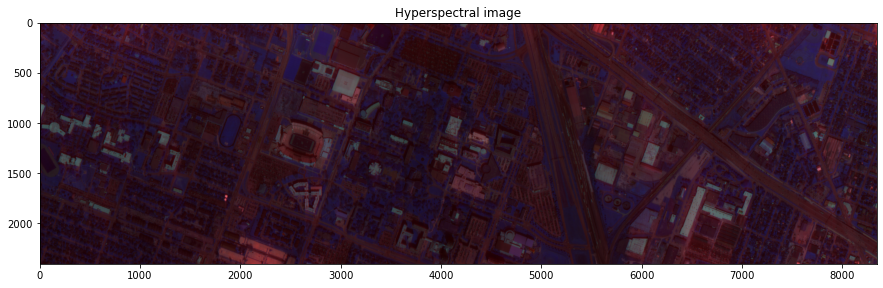

In [21]:
#@title Show Hyperspectral Image

data.show_hs_image()

Loading full LiDAR multispectral intensity image...


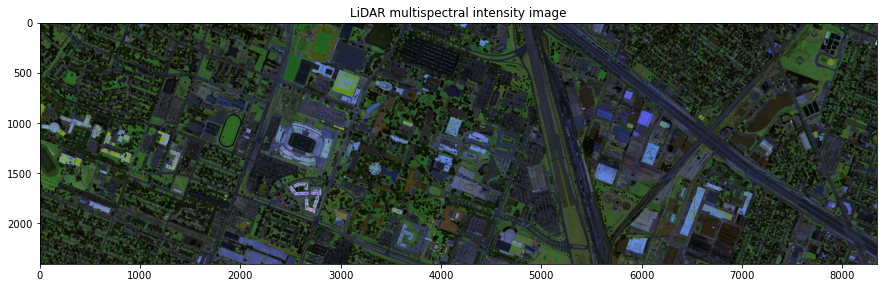

In [22]:
#@title Show LiDAR Multispectral Intensity Color Composite Image

data.show_lidar_ms_image()

Loading full LiDAR DSM image...


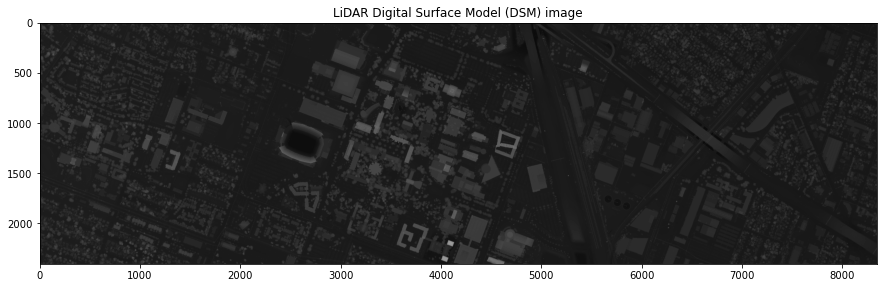

In [23]:
#@title Show LiDAR Digital Surface Model (DSM) Image

data.show_lidar_dsm_image()

Loading full LiDAR hybrid DEM image...


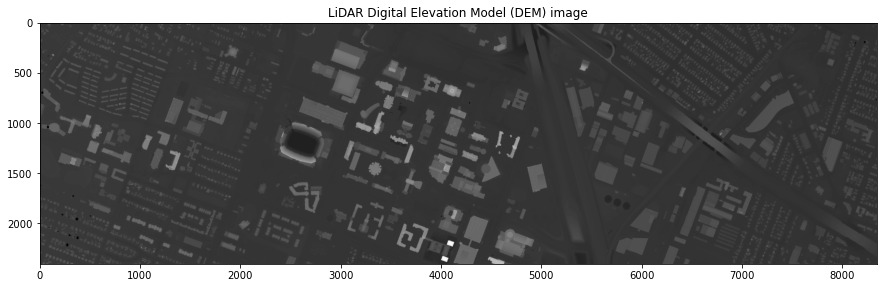

In [24]:
#@title Show LiDAR Digital Elevation Model (DEM) Image from Hybrid Model

data.show_lidar_dem_image()

Loading full LiDAR NDSM image using hybrid DEM...


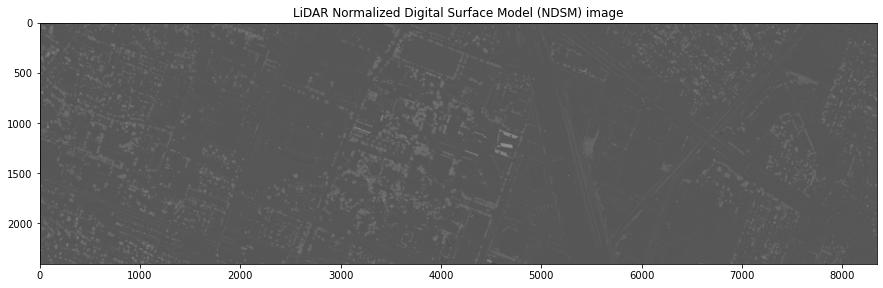

In [25]:
#@title Show LiDAR Normalized Digital Surface Model (NDSM) Image

data.show_lidar_ndsm_image()

In [52]:
dropdown__class_list = widgets.Dropdown(options = UH_2018_CLASS_LIST)

def dropdown__class_list_eventhandler(change):
    if change.new == 'Undefined'

SyntaxError: invalid syntax (Temp/ipykernel_15868/3246147800.py, line 4)

In [ ]:
def run_data_analysis():
    pass

run_data_analysis()

# 6) Experiment Setup Functions

In [53]:
#@title Setup grss_dfc_2018 UH 3-D DenseNet runner function

def run_3d_densenet_uh(val_split, num_neighbor_in_patch, num_iterations, 
                       batch_size, num_epochs, patience, learning_rate):
    """
    Runs the 3D-DenseNet for the University of Houston dataset.
    """

    print('Loading grss_dfc_2018 UH dataset...')
    dataset = UH_DATASET
    dataset.load_full_gt_image()
    dataset.load_full_hs_image()
    print('grss_dfc_2018 UH dataset successfully loaded!')

    print('Getting training and testing indices...')
    train_indices, test_indices = dataset.get_train_test_split(flatten=True)

    data = dataset.hs_image
    gt = dataset.gt_image

    TRAIN_VAL_SPLIT = val_split

    ### Set Constants ###
    INPUT_DIMENSION_CONV = data.shape[-1]

    dataset.clear_all_images()

    TOTAL_SIZE = len(train_indices) + len(test_indices) # total number of samples across all classes
    VAL_SIZE = int(len(train_indices) * TRAIN_VAL_SPLIT)     # total number of samples in the validation dataset
    TRAIN_SIZE = len(train_indices)          # total number of samples in the training dataset
    TEST_SIZE = len(test_indices) # total number of samples in test set
    VALIDATION_SPLIT = 0.8  # 20% for training and 80% for validation and testing

    # Spatial context size (number of neighbours in each spatial direction)
    PATCH_LENGTH = num_neighbor_in_patch

    ITER = num_iterations        # number of iterations to run this model
    CATEGORY = dataset.gt_num_classes

    ### Set Variables ###

    # Get University of Houston 2018 dataset array
    data_UH = data

    # Get University of Houston 2018 ground truth array
    gt_UH = gt

    new_gt_UH = deepcopy(gt_UH) # copy of ground truth array data
    batch_size = batch_size     # number of samples to put through model in one shot
    nb_epoch = num_epochs       # number of epochs to run model for

    img_rows = PATCH_LENGTH * 2 + 1 # number of rows in neighborhood
    img_cols = PATCH_LENGTH * 2 + 1 # number of cols in neighborhood
    bands = INPUT_DIMENSION_CONV    # number of spectral bands
    classes = CATEGORY              # number of label categories

    # Number of epochs with no improvement after which training will be
    # stopped
    patience = patience

    # Take the input data and reshape it from a 3-D array into a 2-D array
    # by taking the product of the first two dimensions as the new first
    # dimension and the product of the remaining dimensions (should be just
    # one) as the second dimension
    data = data_UH.reshape(np.prod(data_UH.shape[:2]), np.prod(data_UH.shape[2:]))

    # Independently standardize each feature, center it, and scale each
    # feature to the unit variance
    data = preprocessing.scale(data)

    # Print variables for verification
    print(f'data_UH.shape={data_UH.shape}')
    print(f'gt_UH.shape={gt_UH.shape}')
    print(f'data_UH.shape[:2]={data_UH.shape[:2]}')
    print(f'np.prod(data_UH.shape[:2])={np.prod(data_UH.shape[:2])}')
    print(f'data_UH.shape[2:]={data_UH.shape[2:]}')
    print(f'np.prod(data_UH.shape[2:])={np.prod(data_UH.shape[2:])}')
    print(f'np.prod(new_gt_UH.shape[:2])={np.prod(new_gt_UH.shape[:2])}')
    print(f'data.shape={data.shape}')

    # Reshape the ground truth to be only one dimension consisting of the
    # product of the first two dimensions
    gt = new_gt_UH.reshape(np.prod(new_gt_UH.shape[:2]), )

    # Create a nd array copy of the dataset with its first three dimensions
    whole_data = data.reshape(data_UH.shape[0], data_UH.shape[1], data_UH.shape[2])

    # Create an nd array copy of the dataset with padding at PATCH_LENGTH
    # distance around the image
    padded_data = zeroPadding_3D(whole_data, PATCH_LENGTH)

    # Adjust training and testing indices

    # Create zeroed out numpy arrays with dimensions 
    # (# training samples, spatial-sample size, spatial-sample size, # bands)
    # and
    # (# testing samples, spatial-sample size, spatial-sample size, # bands)
    train_data = np.zeros((TRAIN_SIZE, 2 * PATCH_LENGTH + 1, 2 * PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))
    test_data = np.zeros((TEST_SIZE, 2 * PATCH_LENGTH + 1, 2 * PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))

    # Initialize statistics lists
    KAPPA_3D_DenseNet = []
    OA_3D_DenseNet = []
    AA_3D_DenseNet = []
    TRAINING_TIME_3D_DenseNet = []
    TESTING_TIME_3D_DenseNet = []
    ELEMENT_ACC_3D_DenseNet = np.zeros((ITER, CATEGORY))

    # A list of random number generator seeds where the seed at each index
    # corresponds to the seed to use at that number iteration
    seeds = [1334]

    # Print variables for verification
    print(f'data_UH.shape={data_UH.shape}')
    print(f'gt_UH.shape={gt_UH.shape}')
    print(f'data_UH.shape[:2]={data_UH.shape[:2]}')
    print(f'np.prod(data_UH.shape[:2])={np.prod(data_UH.shape[:2])}')
    print(f'data_UH.shape[2:]={data_UH.shape[2:]}')
    print(f'np.prod(data_UH.shape[2:])={np.prod(data_UH.shape[2:])}')
    print(f'np.prod(new_gt_UH.shape[:2])={np.prod(new_gt_UH.shape[:2])}')
    print(f'data.shape={data.shape}')
    print(f'padded_data.shape={padded_data.shape}')
    print(f'train_data.shape={train_data.shape}')
    print(f'test_data.shape={test_data.shape}')

    # Run 3-D DenseNet for ITER iterations
    for index_iter in range(ITER):
        print('vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv')
        print(f'>>> Iteration #{index_iter + 1} >>>')

        # Path for saving the best validated model at the model
        # checkpoint
        best_weights_DenseNet_path = 'training_results/university_of_houston/UHouston_best_3D_DenseNet_1' + str(
            index_iter + 1) + '.hdf5'

        # Initialize random seed for sampling function
        np.random.seed(seeds[index_iter])

        print(f'unique train indices: {np.unique(gt[train_indices])}')

        # Create training set class vector
        y_train = gt[train_indices] - 1

        # Convert training set class vector into binary class matrix 
        # for one-hot encoding
        y_train = to_categorical(np.asarray(y_train), num_classes=NUMBER_OF_UH_2018_CLASSES)

        # Create testing set class vector
        y_test = gt[test_indices] - 1

        # Convert testing set class vector into binary class matrix 
        # for one-hot encoding
        y_test = to_categorical(np.asarray(y_test), num_classes=NUMBER_OF_UH_2018_CLASSES)

        # Get row-column pair assignments for training set
        train_assign = indexToAssignment(train_indices, whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)

        # Loop through row-column training assignments to get the set of
        # neighborhood patches for each training sample
        for i in range(len(train_assign)):
            train_data[i] = selectNeighboringPatch(padded_data, train_assign[i][0], train_assign[i][1], PATCH_LENGTH)

        # Get row-column pair assignments for testing set
        test_assign = indexToAssignment(test_indices, whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)
        
        # Loop through row-column testing assignments to get the set of
        # neighborhood patches for each testing sample
        for i in range(len(test_assign)):
            test_data[i] = selectNeighboringPatch(padded_data, test_assign[i][0], test_assign[i][1], PATCH_LENGTH)

        # Shape training and testing dataset features sets to 
        # (#samples, rows, cols, bands)
        x_train_all = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], INPUT_DIMENSION_CONV)
        x_test = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], INPUT_DIMENSION_CONV)

        # Break part of training dataset out into validation dataset
        x_val = x_train_all[-VAL_SIZE:]
        y_val = y_train[-VAL_SIZE:]

        # Remove validation dataset from training dataset
        x_train = x_train_all[:-VAL_SIZE]
        y_train = y_train[:-VAL_SIZE]

        ############################################################################################################
        # Model creation, training, and testing
        model_densenet = model_DenseNet(img_rows, img_cols, bands, classes, learning_rate)

        # Create callback to stop training early if metrics don't improve
        cb_early_stopping = kcallbacks.EarlyStopping(monitor='val_loss', 
            patience=patience, verbose=1, mode='auto')

        # Create callback to save model weights if the model performs
        # better than the previously trained models
        cb_save_best_model = kcallbacks.ModelCheckpoint(best_weights_DenseNet_path, 
            monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


        # Record start time for model training
        model_train_start = time.process_time()
        
        print(f'x_train shape: {x_train.shape}')
        print(f'x_train.reshape: {x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], x_train.shape[3]).shape}')
        print(f'y_train shape: {y_train.shape}')
        print(f'x_val shape: {x_val.shape}')
        print(f'x_val.reshape: {x_val.reshape(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2], x_val.shape[3]).shape}')
        print(f'y_val shape: {y_val.shape}')

        # Train the 3D-DenseNet
        history_3d_densenet = model_densenet.fit(
            x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], x_train.shape[3]), y_train,
            validation_data=(x_val.reshape(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2], x_val.shape[3]), y_val),
            batch_size=batch_size,
            epochs=nb_epoch, shuffle=True, callbacks=[cb_early_stopping, cb_save_best_model])
        
        # Record end time for model training
        model_train_end = time.process_time()

        # Record start time for model evaluation
        model_test_start = time.process_time()

        # Evaluate the trained 3D-DenseNet
        loss_and_metrics = model_densenet.evaluate(
            x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], x_test.shape[3]), y_test,
            batch_size=batch_size)

        # Record end time for model evaluation
        model_test_end = time.process_time()

        # Print time metrics
        print('3D DenseNet Time: ', model_train_end - model_train_start)
        print('3D DenseNet Test time:', model_test_end - model_test_start)

        # Print loss and accuracy metrics
        print('3D DenseNet Test score:', loss_and_metrics[0])
        print('3D DenseNet Test accuracy:', loss_and_metrics[1])

        # Get prediction values for test dataset
        pred_test = model_densenet.predict(
            x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], x_test.shape[3])).argmax(axis=1)
        
        # Store the prediction label counts
        collections.Counter(pred_test)

        # Create test class vector
        gt_test = gt[test_indices] - 1
        
        # Get prediction accuracy metric
        overall_acc = metrics.accuracy_score(pred_test, gt_test)
        
        # Get prediction confusion matrix
        confusion_matrix = metrics.confusion_matrix(pred_test, gt_test)
        
        # Get individual class accuracy as well as average accuracy
        each_acc, average_acc = AA_andEachClassAccuracy(confusion_matrix)
        
        # Get Kappa metric from predictions
        kappa = metrics.cohen_kappa_score(pred_test, gt_test)
        
        # Append all metrics to their respective lists
        KAPPA_3D_DenseNet.append(kappa)
        OA_3D_DenseNet.append(overall_acc)
        AA_3D_DenseNet.append(average_acc)

        # Append training and testing times to their respective lists
        TRAINING_TIME_3D_DenseNet.append(model_train_end - model_train_start)
        TESTING_TIME_3D_DenseNet.append(model_test_end - model_test_start)
        
        # Save individual accuracies to iteration index in element
        # accuracy list
        ELEMENT_ACC_3D_DenseNet[index_iter, :] = each_acc

        print("3D DenseNet finished.")
        print(f'<<< Iteration #{index_iter + 1} <<<')
        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    # Print out the overall training and testing results for the model
    # and save the results to a file
    outputStats(KAPPA_3D_DenseNet, OA_3D_DenseNet, AA_3D_DenseNet, ELEMENT_ACC_3D_DenseNet,
                                TRAINING_TIME_3D_DenseNet, TESTING_TIME_3D_DenseNet,
                                history_3d_densenet, loss_and_metrics, CATEGORY,
                                'training_results/university_of_houston/UH_train_3D_10_.txt',
                                'training_results/university_of_houston/UH_train_3D_element_10_.txt')

# 7) Experiments

In [54]:
#@title Run grss_dfc_2018 UH 3-D Densenet

DEFAULT_VAL_SPLIT = 0.2
DEFAULT_PATCH_SIZE = 1
DEFAULT_ITERATIONS = 1
DEFAULT_BATCH_SIZE = 8
DEFAULT_EPOCHS = 5
DEFAULT_PATIENCE = DEFAULT_EPOCHS
DEFAULT_LEARNING_RATE = 0.0003

run_3d_densenet_uh(val_split=DEFAULT_VAL_SPLIT,
                   num_neighbor_in_patch=DEFAULT_PATCH_SIZE,
                   num_iterations=DEFAULT_ITERATIONS,
                   batch_size=128,
                   num_epochs=DEFAULT_EPOCHS,
                   patience=DEFAULT_PATIENCE,
                   learning_rate=0.001)

# output = widgets.Output()
# button = widgets.Button(description='Run Experiment')

# bounded__val_split = widgets.BoundedFloatText(min=0, max=1, value=DEFAULT_VAL_SPLIT, step=0.1, description='Validation Split')
# bounded__patch = widgets.BoundedIntText(min=1, value=DEFAULT_PATCH_SIZE, step=1, description='Patch neighbors in one direction')
# bounded__iterations = widgets.BoundedIntText(min=1, value=DEFAULT_ITERATIONS, step=1, description='Number of Iterations')
# bounded__batch_size = widgets.BoundedIntText(min=1, value=DEFAULT_BATCH_SIZE, step=1, description='Batch Size')
# bounded__epochs = widgets.BoundedIntText(min=1, value=DEFAULT_EPOCHS, step=1, description='Number of Epochs')
# bounded__patience = widgets.BoundedIntText(min=1, value=DEFAULT_PATIENCE, step=1, description='Number of epochs without improvement before stopping training')
# bounded__learning_rate = widgets.BoundedFloatText(min=0, max=1, value=DEFAULT_LEARNING_RATE, step=0.0001, description='Validation Split')

# # Set 'experiment start' button function
# def start_experiment(obj):
#     print('Starting experiment...')
#     run_3d_densenet_uh(val_split=bounded__val_split.value,
#                        num_neighbor_in_patch=bounded__patch.value,
#                        num_iterations=bounded__iterations.value,
#                        batch_size=bounded__batch_size.value,
#                        num_epochs=bounded__epochs.value,
#                        patience=bounded__patience.value,
#                        learning_rate=bounded__learning_rate.value)

# button.on_click(start_experiment)

# display(bounded__val_split)
# display(bounded__patch)
# display(bounded__iterations)
# display(bounded__batch_size)
# display(bounded__epochs)
# display(bounded__patience)
# display(bounded__learning_rate)
# display(button, output)


Loading grss_dfc_2018 UH dataset...
Loading full ground truth image...
Loading training and test ground truth tiles...
Merging image tiles...
Loading full hyperspectral image...
grss_dfc_2018 UH dataset successfully loaded!
Getting training and testing indices...
data_UH.shape=(2404, 8344, 48)
gt_UH.shape=(2404, 8344)
data_UH.shape[:2]=(2404, 8344)
np.prod(data_UH.shape[:2])=20058976
data_UH.shape[2:]=(48,)
np.prod(data_UH.shape[2:])=48
np.prod(new_gt_UH.shape[:2])=20058976
data.shape=(20058976, 48)
data_UH.shape=(2404, 8344, 48)
gt_UH.shape=(2404, 8344)
data_UH.shape[:2]=(2404, 8344)
np.prod(data_UH.shape[:2])=20058976
data_UH.shape[2:]=(48,)
np.prod(data_UH.shape[2:])=48
np.prod(new_gt_UH.shape[:2])=20058976
data.shape=(20058976, 48)
padded_data.shape=(2406, 8346, 48)
train_data.shape=(2018910, 3, 3, 48)
test_data.shape=(341729, 3, 3, 48)
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
>>> Iteration #1 >>>
unique train indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16

C:\Users\cdgoo\anaconda3\envs\thesis\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


x_train shape: (1615128, 3, 3, 48)
x_train.reshape: (1615128, 1, 3, 3, 48)
y_train shape: (1615128, 20)
x_val shape: (403782, 3, 3, 48)
x_val.reshape: (403782, 1, 3, 3, 48)
y_val shape: (403782, 20)


MemoryError: Unable to allocate 2.60 GiB for an array with shape (1615128, 1, 3, 3, 48) and data type float32

# References and Citations
1. Fernandez-Diaz, Juan Carlos, and Ramesh L. Shrestha. “Data Collection &amp; Processing Report.” 2018 IEEE GRSS Data Fusion Challenge – Fusion of Multispectral LiDAR and Hyperspectral Data, University of Houston, 2017, https://hyperspectral.ee.uh.edu/2018IEEEDocs/DataReport.pdf. 

2. Saurabh Prasad, Bertrand Le Saux, Naoto Yokoya, Ronny Hansch, December 18, 2020, "2018 IEEE GRSS Data Fusion Challenge – Fusion of Multispectral LiDAR and Hyperspectral Data", IEEE Dataport, doi: https://dx.doi.org/10.21227/jnh9-nz89.

3. Zhang C, Li G, Du S, et al. Three-dimensional densely connected convolutional network for hyperspectral remote sensing image classification[J]. Journal of Applied Remote Sensing, 2019, 13(1): 016519.

4. Leeguandong. “Leeguandong/3D-Densenet-for-HSI: Paper：Three-Dimensional Densely Connected Convolutional Network for Hyperspectral Remote Sensing Image Classification.” GitHub, Journal of Applied Remote Sensing, 13(1), 3 Feb. 2019, https://github.com/leeguandong/3D-DenseNet-for-HSI. 